# Импорт библиотек

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

# Устройство для вычислений
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Часть 1. Классификатор 128×128

## Подготовка данных TinyImageNet

In [ ]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # img = Image.open(img_path).convert('RGB')
        image = cv2.imread(img_path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image, label

root = "tiny-imagenet-200/tiny-imagenet-200"

Выбраны стандартные аугментации связанные с геометрией и цветом

In [3]:
train_transform_tiny_image_net = A.Compose([
    A.Resize(160, 160),
    A.RandomResizedCrop(height=128, width=128, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
    
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform_tiny_image_net = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

Всего выбрал 20 классов

In [4]:
selected_classes = [i for i in range(0, 100, 5)]

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform_tiny_image_net)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform_tiny_image_net)

subset_train_samples = [s for s in train_dataset.samples if s[1] in selected_classes]
subset_val_samples = [s for s in val_dataset.samples if s[1] in selected_classes]

class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)

class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image, label


train_subset_dataset = CustomDataset(subset_train_samples, transform=train_transform_tiny_image_net)
val_subset_dataset = CustomDataset(subset_val_samples, transform=val_transform_tiny_image_net)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False)

## Построение архитектуры

Реализовал резидуал блок, но с добавлением трёх ветвей с разными размерами свёрток и дал возможность нейронной сети определять важность каждой из них с помощью дополнительных параметров. Также внутри блока не делал нормализацию, нормализовывал только выход блока. Модель получилась более точная.

In [ ]:
class ResBranchBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.branch1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.branch2 = nn.Conv2d(in_channels, out_channels, 5, stride=stride, padding=2, bias=False)
        self.branch3 = nn.Conv2d(in_channels, out_channels, 7, stride=stride, padding=3, bias=False)

        self.relu = nn.ReLU()
        self.weights = nn.Parameter(torch.zeros(3))

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)

        b1 = self.relu(self.branch1(x))
        b2 = self.relu(self.branch2(x))
        b3 = self.relu(self.branch3(x))

        w = torch.sigmoid(self.weights)
        out = w[0] * b1 + w[1] * b2 + w[2] * b3
        
        return self.relu(out + identity)

In [ ]:
class MyNNImageNetTiny(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.block1 = ResBranchBlock(32, 32, stride=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.block2 = ResBranchBlock(32, 64, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.block3 = ResBranchBlock(64, 128, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.block4 = ResBranchBlock(128, 256, stride=2)
        self.bn4 = nn.BatchNorm2d(256)

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.relu(self.bn0(self.conv0(x)))

        x = self.block1(x)
        x = self.bn1(x)

        x = self.block2(x)
        x = self.bn2(x)
        
        x = self.block3(x)
        x = self.bn3(x)
        
        x = self.block4(x)
        x = self.bn4(x)

        x = self.gap(x)

        x = self.linear(torch.flatten(x, start_dim=1))
        return x

model = MyNNImageNetTiny(num_classes=5)
test_input = torch.randn(1, 3, 128, 128)

output = model(test_input)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")

 Всего параметров: 3,701,873
 Обучаемых параметров: 3,701,873


## Обучение

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm.tqdm(train_loader, desc="Training")
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)

        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        pbar.set_postfix({
            'loss': f'{running_loss / total:.4f}',
            'acc': f'{100. * correct / total:.2f}%'
        })
    
    return running_loss / total, correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm.tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = output.max(1)

            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            pbar.set_postfix({
                'loss': f'{running_loss / total:.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
    
    return running_loss / total, correct / total

def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    print(f"Обучение на {num_epochs} эпох...")
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {100*val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Сохранена лучшая модель с точностью {100*val_acc:.2f}%")
        print()
    return history, best_val_acc

def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_acc(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for h in history:
        ax1.plot(h[0]['train_acc'], label=h[1])

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)

    for h in history:
        ax2.plot(h[0]['val_acc'], label=h[1])

    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

device: cuda
Обучение на 40 эпох...
Эпоха 1/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.71it/s, loss=0.0365, acc=27.60%]


 Train Loss: 0.0396, Train Acc: 22.27%
 Val Loss: 0.0365, Val Acc: 27.60%
Сохранена лучшая модель с точностью 27.60%

Эпоха 2/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.83it/s, loss=0.0339, acc=34.40%]


 Train Loss: 0.0344, Train Acc: 32.42%
 Val Loss: 0.0339, Val Acc: 34.40%
Сохранена лучшая модель с точностью 34.40%

Эпоха 3/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.71it/s, loss=0.0300, acc=42.40%]


 Train Loss: 0.0313, Train Acc: 38.35%
 Val Loss: 0.0300, Val Acc: 42.40%
Сохранена лучшая модель с точностью 42.40%

Эпоха 4/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.43it/s, loss=0.0285, acc=45.30%]


 Train Loss: 0.0288, Train Acc: 43.03%
 Val Loss: 0.0285, Val Acc: 45.30%
Сохранена лучшая модель с точностью 45.30%

Эпоха 5/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.51it/s, loss=0.0265, acc=47.40%]


 Train Loss: 0.0269, Train Acc: 46.84%
 Val Loss: 0.0265, Val Acc: 47.40%
Сохранена лучшая модель с точностью 47.40%

Эпоха 6/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.71it/s, loss=0.0257, acc=49.40%]


 Train Loss: 0.0252, Train Acc: 50.30%
 Val Loss: 0.0257, Val Acc: 49.40%
Сохранена лучшая модель с точностью 49.40%

Эпоха 7/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.06it/s, loss=0.0264, acc=47.40%]


 Train Loss: 0.0237, Train Acc: 53.14%
 Val Loss: 0.0264, Val Acc: 47.40%

Эпоха 8/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.25it/s, loss=0.0237, acc=53.20%]


 Train Loss: 0.0221, Train Acc: 56.10%
 Val Loss: 0.0237, Val Acc: 53.20%
Сохранена лучшая модель с точностью 53.20%

Эпоха 9/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.30it/s, loss=0.0234, acc=55.50%]


 Train Loss: 0.0207, Train Acc: 59.07%
 Val Loss: 0.0234, Val Acc: 55.50%
Сохранена лучшая модель с точностью 55.50%

Эпоха 10/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.12it/s, loss=0.0221, acc=58.40%]


 Train Loss: 0.0196, Train Acc: 61.40%
 Val Loss: 0.0221, Val Acc: 58.40%
Сохранена лучшая модель с точностью 58.40%

Эпоха 11/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.14it/s, loss=0.0217, acc=58.00%]


 Train Loss: 0.0183, Train Acc: 64.34%
 Val Loss: 0.0217, Val Acc: 58.00%

Эпоха 12/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.15it/s, loss=0.0201, acc=59.90%]


 Train Loss: 0.0172, Train Acc: 65.68%
 Val Loss: 0.0201, Val Acc: 59.90%
Сохранена лучшая модель с точностью 59.90%

Эпоха 13/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.55it/s, loss=0.0196, acc=62.10%]


 Train Loss: 0.0159, Train Acc: 68.29%
 Val Loss: 0.0196, Val Acc: 62.10%
Сохранена лучшая модель с точностью 62.10%

Эпоха 14/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.53it/s, loss=0.0201, acc=62.50%]


 Train Loss: 0.0153, Train Acc: 69.84%
 Val Loss: 0.0201, Val Acc: 62.50%
Сохранена лучшая модель с точностью 62.50%

Эпоха 15/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.29it/s, loss=0.0204, acc=62.20%]


 Train Loss: 0.0143, Train Acc: 71.57%
 Val Loss: 0.0204, Val Acc: 62.20%

Эпоха 16/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.58it/s, loss=0.0190, acc=64.70%]


 Train Loss: 0.0134, Train Acc: 73.40%
 Val Loss: 0.0190, Val Acc: 64.70%
Сохранена лучшая модель с точностью 64.70%

Эпоха 17/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.59it/s, loss=0.0190, acc=63.40%]


 Train Loss: 0.0124, Train Acc: 75.18%
 Val Loss: 0.0190, Val Acc: 63.40%

Эпоха 18/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.84it/s, loss=0.0187, acc=64.60%]


 Train Loss: 0.0113, Train Acc: 77.45%
 Val Loss: 0.0187, Val Acc: 64.60%

Эпоха 19/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.49it/s, loss=0.0187, acc=65.10%]


 Train Loss: 0.0106, Train Acc: 79.20%
 Val Loss: 0.0187, Val Acc: 65.10%
Сохранена лучшая модель с точностью 65.10%

Эпоха 20/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.47it/s, loss=0.0184, acc=66.60%]


 Train Loss: 0.0099, Train Acc: 80.80%
 Val Loss: 0.0184, Val Acc: 66.60%
Сохранена лучшая модель с точностью 66.60%

Эпоха 21/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.47it/s, loss=0.0179, acc=66.60%]


 Train Loss: 0.0091, Train Acc: 81.90%
 Val Loss: 0.0179, Val Acc: 66.60%

Эпоха 22/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.72it/s, loss=0.0188, acc=64.30%]


 Train Loss: 0.0084, Train Acc: 83.27%
 Val Loss: 0.0188, Val Acc: 64.30%

Эпоха 23/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.82it/s, loss=0.0185, acc=66.50%]


 Train Loss: 0.0078, Train Acc: 84.48%
 Val Loss: 0.0185, Val Acc: 66.50%

Эпоха 24/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.24it/s, loss=0.0184, acc=65.70%]


 Train Loss: 0.0070, Train Acc: 86.34%
 Val Loss: 0.0184, Val Acc: 65.70%

Эпоха 25/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.25it/s, loss=0.0184, acc=66.10%]


 Train Loss: 0.0065, Train Acc: 87.53%
 Val Loss: 0.0184, Val Acc: 66.10%

Эпоха 26/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 10.67it/s, loss=0.0201, acc=66.10%]


 Train Loss: 0.0062, Train Acc: 87.94%
 Val Loss: 0.0201, Val Acc: 66.10%

Эпоха 27/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.55it/s, loss=0.0181, acc=67.90%]


 Train Loss: 0.0057, Train Acc: 89.03%
 Val Loss: 0.0181, Val Acc: 67.90%
Сохранена лучшая модель с точностью 67.90%

Эпоха 28/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.55it/s, loss=0.0191, acc=68.50%]


 Train Loss: 0.0052, Train Acc: 90.22%
 Val Loss: 0.0191, Val Acc: 68.50%
Сохранена лучшая модель с точностью 68.50%

Эпоха 29/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 10.59it/s, loss=0.0186, acc=69.60%]


 Train Loss: 0.0047, Train Acc: 90.99%
 Val Loss: 0.0186, Val Acc: 69.60%
Сохранена лучшая модель с точностью 69.60%

Эпоха 30/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.49it/s, loss=0.0177, acc=68.60%]


 Train Loss: 0.0042, Train Acc: 92.38%
 Val Loss: 0.0177, Val Acc: 68.60%

Эпоха 31/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.79it/s, loss=0.0188, acc=68.30%]


 Train Loss: 0.0038, Train Acc: 93.04%
 Val Loss: 0.0188, Val Acc: 68.30%

Эпоха 32/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.10it/s, loss=0.0191, acc=68.00%]


 Train Loss: 0.0039, Train Acc: 92.82%
 Val Loss: 0.0191, Val Acc: 68.00%

Эпоха 33/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.20it/s, loss=0.0195, acc=69.10%]


 Train Loss: 0.0036, Train Acc: 93.18%
 Val Loss: 0.0195, Val Acc: 69.10%

Эпоха 34/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.33it/s, loss=0.0194, acc=68.10%]


 Train Loss: 0.0031, Train Acc: 94.32%
 Val Loss: 0.0194, Val Acc: 68.10%

Эпоха 35/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.35it/s, loss=0.0210, acc=66.90%]


 Train Loss: 0.0030, Train Acc: 94.43%
 Val Loss: 0.0210, Val Acc: 66.90%

Эпоха 36/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.90it/s, loss=0.0206, acc=68.00%]


 Train Loss: 0.0029, Train Acc: 94.73%
 Val Loss: 0.0206, Val Acc: 68.00%

Эпоха 37/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.11it/s, loss=0.0206, acc=69.70%]


 Train Loss: 0.0026, Train Acc: 95.58%
 Val Loss: 0.0206, Val Acc: 69.70%
Сохранена лучшая модель с точностью 69.70%

Эпоха 38/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.35it/s, loss=0.0194, acc=70.40%]


 Train Loss: 0.0024, Train Acc: 95.69%
 Val Loss: 0.0194, Val Acc: 70.40%
Сохранена лучшая модель с точностью 70.40%

Эпоха 39/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.19it/s, loss=0.0212, acc=66.00%]


 Train Loss: 0.0023, Train Acc: 95.80%
 Val Loss: 0.0212, Val Acc: 66.00%

Эпоха 40/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.34it/s, loss=0.0214, acc=66.80%]


 Train Loss: 0.0024, Train Acc: 95.48%
 Val Loss: 0.0214, Val Acc: 66.80%



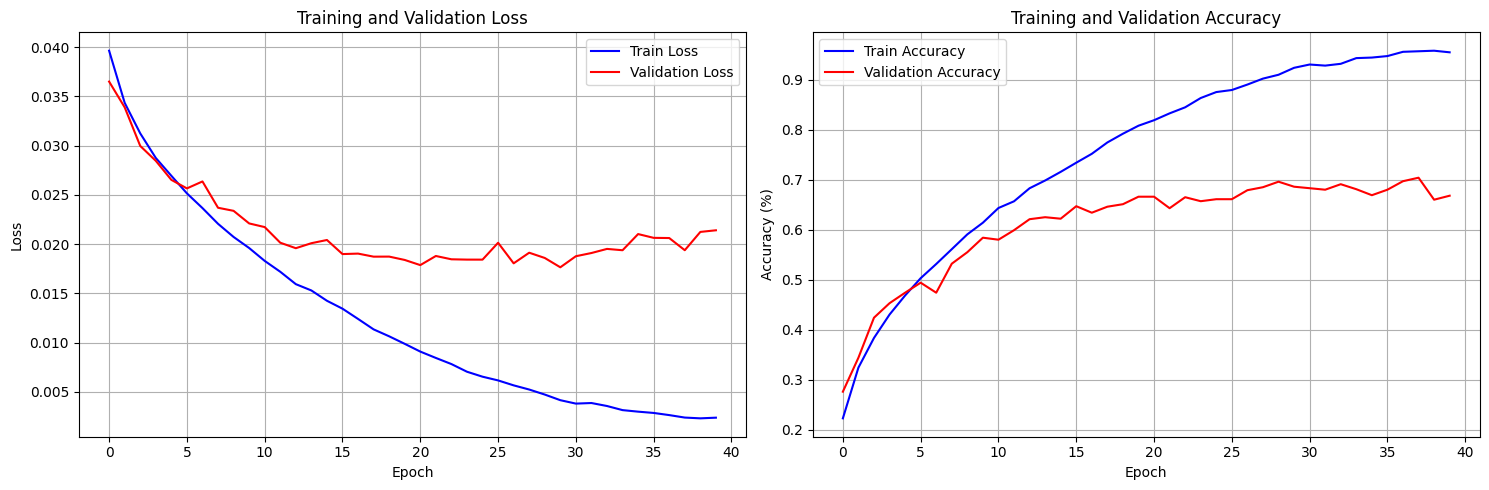

In [8]:
model = MyNNImageNetTiny(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print('device:', device)
history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,    
    criterion=criterion,
    device=device,
    num_epochs=40
)

plot_training_history(history)

## Тест лучшей модели на валидации

In [ ]:
def test(model, test_loader, classes, device):
    model.to(device)
    model.eval()

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            all_targets.append(target.cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())

    targets = np.concatenate(all_targets)
    predictions = np.concatenate(all_predictions)

    acc = accuracy_score(targets, predictions)
    cm = confusion_matrix(targets, predictions)
    
    report_str = classification_report(
        targets, predictions,
        target_names=classes,
        digits=4,
        zero_division=0
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=classes,
        yticklabels=classes,
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f'Confusion Matrix (Accuracy: {acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    print(f"\n✅ Test Accuracy: {100 * acc:.2f}%\n")
    print("📊 Classification Report:")
    print(report_str)

    return {
        'accuracy': acc,
        'report': report_str,
        'confusion_matrix': cm,
        'predictions': predictions,
        'targets': targets
    }

def load_tiny_imagenet_labels(words_path="tiny-imagenet-200/tiny-imagenet-200/words.txt"):
    labels = {}
    with open(words_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                wnid = parts[0]
                desc = parts[1]
                labels[wnid] = desc
    return labels

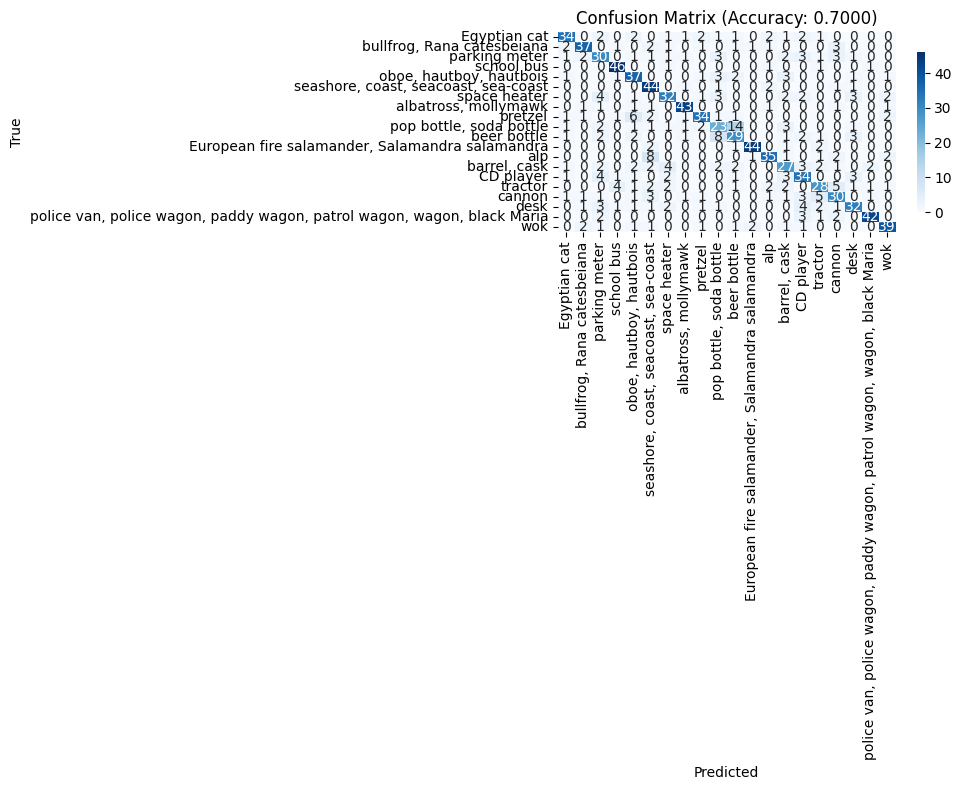


✅ Test Accuracy: 70.00%

📊 Classification Report:
                                                                         precision    recall  f1-score   support

                                                           Egyptian cat     0.7727    0.6800    0.7234        50
                                             bullfrog, Rana catesbeiana     0.8222    0.7400    0.7789        50
                                                          parking meter     0.5556    0.6000    0.5769        50
                                                             school bus     0.8364    0.9200    0.8762        50
                                                oboe, hautboy, hautbois     0.6379    0.7400    0.6852        50
                                   seashore, coast, seacoast, sea-coast     0.6286    0.8800    0.7333        50
                                                           space heater     0.6809    0.6400    0.6598        50
                                            

In [ ]:
model_final_test = MyNNImageNetTiny(20)

checkpoint = torch.load('best_model_classifire.pth', map_location=device)
model_final_test.load_state_dict(checkpoint)

calsses_names = load_tiny_imagenet_labels()
calsses = [calsses_names[val_dataset.class_names[i]] for i in selected_classes] 

results = test(model_final_test, val_loader, calsses, device)

Итоговая модель очень переобучена. Точность, возможно, адекватная, учитывая, что всего 20 классов и модель небольшая.

# Часть 2. Базовая U-Net на "Луне"

Требования к архитектуре U-Net:
1) Глубина: 4 уровня down/4 up (энкодер-декодер с skip-связями).
2) Базовые каналы на первом уровне: 32 или 64
3) Даунсемплинг: stride 2 или MaxPool
4) Итоговый слой: 1 канал с сигмоидой (бинарная сегментация).
5) Ограничение на количество параметров: до ~2.5M
6) Вход: 128×128×3

Обучение:
1) Лосс: BCEWithLogitsLoss или Dice Loss, допустимо комбинировать
2) Метрики для мониторинга: IoU (Jaccard), Dice, Pixel Accuracy
3) Аугментации: горизонтальные/вертикальные флипы, лёгкие геометрические и цветовые — по желанию

## Подготовка данных

In [ ]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground', 
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)
        
        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids
        
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")
        
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = (mask > 0).astype(np.float32)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask

train_augmentation_moon = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, border_mode=cv2.BORDER_REFLECT, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.MedianBlur(blur_limit=5, p=0.1),
    ], p=0.3),
    
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, p=0.6),
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=0.4),

    # вырезание частей изображения для маленьких объектов
    A.RandomResizedCrop(height=256, width=256, scale=(0.3, 1.0), ratio=(0.8, 1.2), p=0.3),

    # добавление различных артефактов
    A.OneOf([
        A.CoarseDropout(
            max_holes=8, 
            max_height=16, 
            max_width=16, 
            min_holes=2, 
            min_height=4, 
            min_width=4,
            fill_value=0,
            p=0.7
        ),
        A.Cutout(
            num_holes=6, 
            max_h_size=12, 
            max_w_size=12, 
            fill_value=0,
            p=0.3
        ),
    ], p=0.25), 
    
    A.Resize(128, 128),
])

preprocessing_moon = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation_moon = A.Compose([
    A.Resize(128, 128),
])

d:\model_descriptor\.venv\Lib\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:


DATA_ROOT = 'D:\model_descriptor\ML_MAGA\MOON_SEGMENTATION_BINARY'

images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation_moon,
    preprocessing=preprocessing_moon
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation_moon,
    preprocessing=preprocessing_moon
)

BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")

Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 20
Батчей в val: 5


Размер батча изображений: torch.Size([4, 3, 128, 128])
Размер батча масок: torch.Size([4, 128, 128])


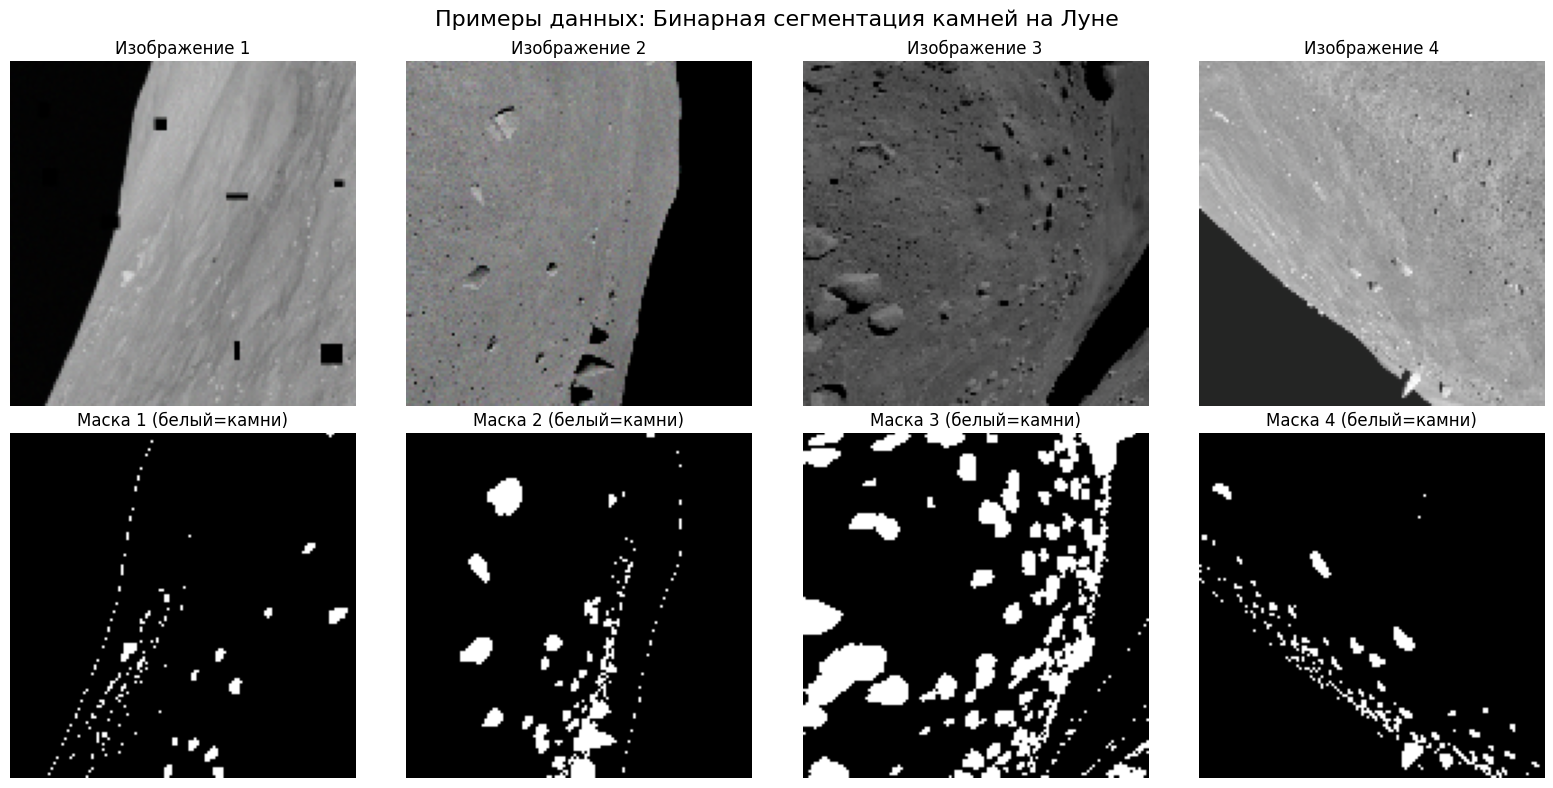

In [ ]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

images, masks = next(iter(train_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()

## Построение модели

Объяснение архитектуры:
1) Число каналов в encoder изменяется следующим образом: 32, 64, 128, 256.
2) Блок свёртки сначала сжимает активацию в 4 раза свёрткой 3 на 3. Если число входных каналов слишком мало, то расширяет до 16 или сразу до требуемого выхода. Далее число каналов расширяется до заданного числа свёрткой 1 на 1. Всё это нужно для оптимизации модели.
3) В качестве downsampling использована свёртка 3x3 со stride=2 и padding=1.

In [14]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        
        mid_channels = min(max(in_channels // 4, 16), out_channels)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(mid_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super(UNet, self).__init__()
        
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            self.encoder_blocks.append(nn.Conv2d(feature, feature, kernel_size=3, padding=1, stride=2))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        features_reversed = list(reversed(features))
        for feature in features_reversed:
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")
    
    def forward(self, x):

        skip_connections = []

        for idx in range(0, len(self.encoder_blocks), 2):
            x = self.encoder_blocks[idx](x)
            skip_connections.append(x)
            x = self.encoder_blocks[idx+1](x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], 
                                mode='bilinear', align_corners=True)
            
            x = torch.cat([skip_connection, x], dim=1)
            
            x = self.decoder_blocks[idx + 1](x)

        # output = torch.sigmoid(self.final_conv(x))
        output = self.final_conv(x)
        
        return output


model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])

test_input = torch.randn(1, 3, 128, 128)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")

Параметров: 2,556,241
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])
 Всего параметров: 2,556,241
 Обучаемых параметров: 2,556,241


In [15]:
print(model)

UNet(
  (encoder_blocks): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): R

## Функция ошибки

In [16]:
class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        
        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()
    
    return (correct / total).item()

## Обучение

In [17]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    pbar = tqdm.tqdm(train_loader, desc="Training")
    
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
        
        running_loss += loss.item()
        running_dice += dice
        running_iou += iou
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })
    
    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)
    
    return avg_loss, avg_dice, avg_iou


def validate_epoch(model, val_loader, criterion, device):
    
    model.eval()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0
    
    pbar = tqdm.tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })
    
    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)
    
    return avg_loss, avg_dice, avg_iou, avg_acc

In [32]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)
    
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        # Здесь происходит основное обучение
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Валидация 
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Обновляем learning rate (проверяем на )
        if scheduler is not None:
            scheduler.step() # val_dice
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        # Сохраняем всю нашу историю
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Выводим результаты
        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")
        
        # Сохраняем лучшую модел, можно сохранять по метрике или loss
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
                'val_acc': val_acc
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    
    print(f"Лучший Val Dice: {best_val_dice:.4f}") 
    
    return history

Здесь сделал сброс lr циклично, чтобы обучение не останавливалось слишком быстро

In [33]:
# Настройка обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")

model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])

# Функция потерь (комбинированная BCE + Dice)
criterion = CombinedLoss(bce_weight=0.3, dice_weight=0.7)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,        # ← каждые 10 эпох — рестарт
    T_mult=2,      # ← следующий цикл в 2× длиннее
    eta_min=1e-6   # ← минимальный LR
)

NUM_EPOCHS = 100

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path='best_moon_unet.pth'
)

  Используем устройство: cuda
Параметров: 2,556,241
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
Эпоха 1/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 30.38it/s, loss=0.7310, dice=0.2857, iou=0.1666, acc=0.9003]



 Результаты эпохи 1:
  Train - Loss: 0.7460, Dice: 0.3005, IoU: 0.1821
  Val   - Loss: 0.7536, Dice: 0.2169, IoU: 0.1224, Acc: 0.9082
  LR: 0.000976
  Сохранена лучшая модель! Dice: 0.2169
Эпоха 2/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.90it/s, loss=0.6665, dice=0.4450, iou=0.2862, acc=0.8606]



 Результаты эпохи 2:
  Train - Loss: 0.6933, Dice: 0.3666, IoU: 0.2294
  Val   - Loss: 0.7064, Dice: 0.3419, IoU: 0.2113, Acc: 0.8384
  LR: 0.000905
  Сохранена лучшая модель! Dice: 0.3419
Эпоха 3/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.23it/s, loss=0.6768, dice=0.4484, iou=0.2890, acc=0.8397]



 Результаты эпохи 3:
  Train - Loss: 0.6608, Dice: 0.4000, IoU: 0.2539
  Val   - Loss: 0.6942, Dice: 0.3923, IoU: 0.2474, Acc: 0.8527
  LR: 0.000794
  Сохранена лучшая модель! Dice: 0.3923
Эпоха 4/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.53it/s, loss=0.5666, dice=0.5414, iou=0.3712, acc=0.9013]



 Результаты эпохи 4:
  Train - Loss: 0.6446, Dice: 0.3954, IoU: 0.2514
  Val   - Loss: 0.6052, Dice: 0.4588, IoU: 0.3022, Acc: 0.9012
  LR: 0.000655
  Сохранена лучшая модель! Dice: 0.4588
Эпоха 5/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.49it/s, loss=0.6128, dice=0.4312, iou=0.2748, acc=0.8031]



 Результаты эпохи 5:
  Train - Loss: 0.6201, Dice: 0.4088, IoU: 0.2636
  Val   - Loss: 0.6786, Dice: 0.3328, IoU: 0.2024, Acc: 0.7708
  LR: 0.000501
Эпоха 6/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.41it/s, loss=0.5495, dice=0.5037, iou=0.3366, acc=0.9166]



 Результаты эпохи 6:
  Train - Loss: 0.6032, Dice: 0.4387, IoU: 0.2855
  Val   - Loss: 0.5901, Dice: 0.4247, IoU: 0.2746, Acc: 0.9211
  LR: 0.000346
Эпоха 7/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.17it/s, loss=0.5504, dice=0.5230, iou=0.3541, acc=0.8588]



 Результаты эпохи 7:
  Train - Loss: 0.5813, Dice: 0.4570, IoU: 0.2992
  Val   - Loss: 0.5975, Dice: 0.4410, IoU: 0.2863, Acc: 0.8595
  LR: 0.000207
Эпоха 8/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.07it/s, loss=0.5150, dice=0.5594, iou=0.3883, acc=0.8930]



 Результаты эпохи 8:
  Train - Loss: 0.5885, Dice: 0.4230, IoU: 0.2749
  Val   - Loss: 0.5652, Dice: 0.4693, IoU: 0.3113, Acc: 0.8916
  LR: 0.000096
  Сохранена лучшая модель! Dice: 0.4693
Эпоха 9/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.57it/s, loss=0.5041, dice=0.5730, iou=0.4016, acc=0.8987]



 Результаты эпохи 9:
  Train - Loss: 0.5941, Dice: 0.4069, IoU: 0.2607
  Val   - Loss: 0.5563, Dice: 0.4854, IoU: 0.3249, Acc: 0.8964
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4854
Эпоха 10/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.47it/s, loss=0.5109, dice=0.5716, iou=0.4001, acc=0.8965]



 Результаты эпохи 10:
  Train - Loss: 0.5872, Dice: 0.4233, IoU: 0.2736
  Val   - Loss: 0.5644, Dice: 0.4812, IoU: 0.3212, Acc: 0.8928
  LR: 0.001000
Эпоха 11/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.15it/s, loss=0.5792, dice=0.5082, iou=0.3407, acc=0.9108]



 Результаты эпохи 11:
  Train - Loss: 0.5928, Dice: 0.4030, IoU: 0.2599
  Val   - Loss: 0.6075, Dice: 0.4338, IoU: 0.2853, Acc: 0.8975
  LR: 0.000994
Эпоха 12/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s, loss=0.5129, dice=0.5247, iou=0.3556, acc=0.8760]



 Результаты эпохи 12:
  Train - Loss: 0.5782, Dice: 0.4093, IoU: 0.2624
  Val   - Loss: 0.5571, Dice: 0.4478, IoU: 0.2930, Acc: 0.8800
  LR: 0.000976
Эпоха 13/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s, loss=0.6955, dice=0.3678, iou=0.2254, acc=0.7123]



 Результаты эпохи 13:
  Train - Loss: 0.5578, Dice: 0.4276, IoU: 0.2789
  Val   - Loss: 0.7326, Dice: 0.2999, IoU: 0.1791, Acc: 0.7176
  LR: 0.000946
Эпоха 14/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.91it/s, loss=0.5340, dice=0.4589, iou=0.2978, acc=0.8533]



 Результаты эпохи 14:
  Train - Loss: 0.5701, Dice: 0.3979, IoU: 0.2574
  Val   - Loss: 0.5869, Dice: 0.3860, IoU: 0.2417, Acc: 0.8518
  LR: 0.000905
Эпоха 15/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s, loss=0.4845, dice=0.5186, iou=0.3501, acc=0.9089]



 Результаты эпохи 15:
  Train - Loss: 0.5621, Dice: 0.4115, IoU: 0.2642
  Val   - Loss: 0.5402, Dice: 0.4175, IoU: 0.2676, Acc: 0.9139
  LR: 0.000854
Эпоха 16/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.20it/s, loss=0.4546, dice=0.5566, iou=0.3856, acc=0.8959]



 Результаты эпохи 16:
  Train - Loss: 0.5439, Dice: 0.4297, IoU: 0.2761
  Val   - Loss: 0.5252, Dice: 0.4530, IoU: 0.2982, Acc: 0.8845
  LR: 0.000794
Эпоха 17/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.59it/s, loss=0.4559, dice=0.5392, iou=0.3691, acc=0.9170]



 Результаты эпохи 17:
  Train - Loss: 0.5542, Dice: 0.4078, IoU: 0.2612
  Val   - Loss: 0.4905, Dice: 0.4758, IoU: 0.3204, Acc: 0.9278
  LR: 0.000727
Эпоха 18/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.21it/s, loss=0.4368, dice=0.5567, iou=0.3857, acc=0.9123]



 Результаты эпохи 18:
  Train - Loss: 0.5450, Dice: 0.4223, IoU: 0.2714
  Val   - Loss: 0.4841, Dice: 0.4840, IoU: 0.3250, Acc: 0.9179
  LR: 0.000655
Эпоха 19/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.51it/s, loss=0.4419, dice=0.5668, iou=0.3955, acc=0.9074]



 Результаты эпохи 19:
  Train - Loss: 0.5278, Dice: 0.4429, IoU: 0.2900
  Val   - Loss: 0.5063, Dice: 0.4687, IoU: 0.3116, Acc: 0.8973
  LR: 0.000579
Эпоха 20/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.80it/s, loss=0.4388, dice=0.5610, iou=0.3899, acc=0.9108]



 Результаты эпохи 20:
  Train - Loss: 0.5190, Dice: 0.4518, IoU: 0.2953
  Val   - Loss: 0.4823, Dice: 0.4894, IoU: 0.3286, Acc: 0.9107
  LR: 0.000501
  Сохранена лучшая модель! Dice: 0.4894
Эпоха 21/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.29it/s, loss=0.4272, dice=0.5742, iou=0.4028, acc=0.9047]



 Результаты эпохи 21:
  Train - Loss: 0.5288, Dice: 0.4421, IoU: 0.2887
  Val   - Loss: 0.4844, Dice: 0.4854, IoU: 0.3262, Acc: 0.9046
  LR: 0.000422
Эпоха 22/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s, loss=0.4190, dice=0.5774, iou=0.4059, acc=0.9166]



 Результаты эпохи 22:
  Train - Loss: 0.5218, Dice: 0.4404, IoU: 0.2871
  Val   - Loss: 0.4756, Dice: 0.4876, IoU: 0.3277, Acc: 0.9157
  LR: 0.000346
Эпоха 23/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.66it/s, loss=0.4000, dice=0.5963, iou=0.4248, acc=0.9103]



 Результаты эпохи 23:
  Train - Loss: 0.5074, Dice: 0.4638, IoU: 0.3080
  Val   - Loss: 0.4640, Dice: 0.5011, IoU: 0.3399, Acc: 0.9088
  LR: 0.000274
  Сохранена лучшая модель! Dice: 0.5011
Эпоха 24/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.40it/s, loss=0.3971, dice=0.5997, iou=0.4283, acc=0.9182]



 Результаты эпохи 24:
  Train - Loss: 0.4971, Dice: 0.4762, IoU: 0.3185
  Val   - Loss: 0.4562, Dice: 0.5035, IoU: 0.3426, Acc: 0.9171
  LR: 0.000207
  Сохранена лучшая модель! Dice: 0.5035
Эпоха 25/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.44it/s, loss=0.3975, dice=0.5980, iou=0.4266, acc=0.9109]



 Результаты эпохи 25:
  Train - Loss: 0.5005, Dice: 0.4758, IoU: 0.3173
  Val   - Loss: 0.4638, Dice: 0.4957, IoU: 0.3358, Acc: 0.9069
  LR: 0.000147
Эпоха 26/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.49it/s, loss=0.3993, dice=0.5989, iou=0.4275, acc=0.9123]



 Результаты эпохи 26:
  Train - Loss: 0.4821, Dice: 0.4938, IoU: 0.3349
  Val   - Loss: 0.4603, Dice: 0.5010, IoU: 0.3400, Acc: 0.9088
  LR: 0.000096
Эпоха 27/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s, loss=0.3953, dice=0.6010, iou=0.4296, acc=0.9131]



 Результаты эпохи 27:
  Train - Loss: 0.4868, Dice: 0.4893, IoU: 0.3294
  Val   - Loss: 0.4597, Dice: 0.5000, IoU: 0.3395, Acc: 0.9089
  LR: 0.000055
Эпоха 28/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.95it/s, loss=0.3970, dice=0.5998, iou=0.4284, acc=0.9109]



 Результаты эпохи 28:
  Train - Loss: 0.4914, Dice: 0.4806, IoU: 0.3229
  Val   - Loss: 0.4630, Dice: 0.4967, IoU: 0.3367, Acc: 0.9062
  LR: 0.000025
Эпоха 29/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.34it/s, loss=0.3982, dice=0.5997, iou=0.4282, acc=0.9118]



 Результаты эпохи 29:
  Train - Loss: 0.4720, Dice: 0.5071, IoU: 0.3447
  Val   - Loss: 0.4642, Dice: 0.4965, IoU: 0.3367, Acc: 0.9069
  LR: 0.000007
Эпоха 30/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.26it/s, loss=0.3970, dice=0.5984, iou=0.4269, acc=0.9149]



 Результаты эпохи 30:
  Train - Loss: 0.4878, Dice: 0.4817, IoU: 0.3223
  Val   - Loss: 0.4594, Dice: 0.4987, IoU: 0.3388, Acc: 0.9129
  LR: 0.001000
Эпоха 31/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s, loss=0.4096, dice=0.5795, iou=0.4080, acc=0.9017]



 Результаты эпохи 31:
  Train - Loss: 0.4822, Dice: 0.4963, IoU: 0.3382
  Val   - Loss: 0.4650, Dice: 0.4985, IoU: 0.3372, Acc: 0.9037
  LR: 0.000998
Эпоха 32/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.20it/s, loss=0.4178, dice=0.5688, iou=0.3975, acc=0.8968]



 Результаты эпохи 32:
  Train - Loss: 0.5088, Dice: 0.4619, IoU: 0.3047
  Val   - Loss: 0.4884, Dice: 0.4677, IoU: 0.3105, Acc: 0.8901
  LR: 0.000994
Эпоха 33/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s, loss=0.4218, dice=0.5679, iou=0.3966, acc=0.9019]



 Результаты эпохи 33:
  Train - Loss: 0.5206, Dice: 0.4383, IoU: 0.2886
  Val   - Loss: 0.4894, Dice: 0.4677, IoU: 0.3116, Acc: 0.8909
  LR: 0.000986
Эпоха 34/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.56it/s, loss=0.4128, dice=0.5741, iou=0.4026, acc=0.8891]



 Результаты эпохи 34:
  Train - Loss: 0.5090, Dice: 0.4557, IoU: 0.3008
  Val   - Loss: 0.4759, Dice: 0.4827, IoU: 0.3231, Acc: 0.8866
  LR: 0.000976
Эпоха 35/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.06it/s, loss=0.4619, dice=0.5098, iou=0.3421, acc=0.8776]



 Результаты эпохи 35:
  Train - Loss: 0.4983, Dice: 0.4694, IoU: 0.3126
  Val   - Loss: 0.5196, Dice: 0.4253, IoU: 0.2743, Acc: 0.8714
  LR: 0.000962
Эпоха 36/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.98it/s, loss=0.4068, dice=0.5758, iou=0.4042, acc=0.9037]



 Результаты эпохи 36:
  Train - Loss: 0.5067, Dice: 0.4609, IoU: 0.3081
  Val   - Loss: 0.4757, Dice: 0.4693, IoU: 0.3136, Acc: 0.9063
  LR: 0.000946
Эпоха 37/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.78it/s, loss=0.3973, dice=0.5951, iou=0.4236, acc=0.9111]



 Результаты эпохи 37:
  Train - Loss: 0.5253, Dice: 0.4321, IoU: 0.2845
  Val   - Loss: 0.4493, Dice: 0.5146, IoU: 0.3513, Acc: 0.9088
  LR: 0.000926
  Сохранена лучшая модель! Dice: 0.5146
Эпоха 38/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.43it/s, loss=0.3972, dice=0.5856, iou=0.4140, acc=0.9134]



 Результаты эпохи 38:
  Train - Loss: 0.5076, Dice: 0.4624, IoU: 0.3053
  Val   - Loss: 0.4556, Dice: 0.4921, IoU: 0.3340, Acc: 0.9163
  LR: 0.000905
Эпоха 39/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.92it/s, loss=0.4640, dice=0.5265, iou=0.3573, acc=0.8680]



 Результаты эпохи 39:
  Train - Loss: 0.5160, Dice: 0.4449, IoU: 0.2900
  Val   - Loss: 0.5212, Dice: 0.4436, IoU: 0.2878, Acc: 0.8614
  LR: 0.000880
Эпоха 40/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.53it/s, loss=0.4502, dice=0.5336, iou=0.3639, acc=0.8690]



 Результаты эпохи 40:
  Train - Loss: 0.5023, Dice: 0.4628, IoU: 0.3062
  Val   - Loss: 0.5107, Dice: 0.4423, IoU: 0.2890, Acc: 0.8663
  LR: 0.000854
Эпоха 41/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.86it/s, loss=0.3843, dice=0.6025, iou=0.4311, acc=0.9111]



 Результаты эпохи 41:
  Train - Loss: 0.5019, Dice: 0.4616, IoU: 0.3076
  Val   - Loss: 0.4429, Dice: 0.5118, IoU: 0.3506, Acc: 0.9096
  LR: 0.000825
Эпоха 42/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.74it/s, loss=0.3962, dice=0.5855, iou=0.4140, acc=0.9237]



 Результаты эпохи 42:
  Train - Loss: 0.5174, Dice: 0.4377, IoU: 0.2910
  Val   - Loss: 0.4419, Dice: 0.5113, IoU: 0.3497, Acc: 0.9269
  LR: 0.000794
Эпоха 43/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.40it/s, loss=0.4094, dice=0.5693, iou=0.3980, acc=0.9173]



 Результаты эпохи 43:
  Train - Loss: 0.4807, Dice: 0.4898, IoU: 0.3325
  Val   - Loss: 0.4657, Dice: 0.4846, IoU: 0.3258, Acc: 0.9138
  LR: 0.000761
Эпоха 44/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.22it/s, loss=0.4079, dice=0.5771, iou=0.4056, acc=0.8876]



 Результаты эпохи 44:
  Train - Loss: 0.4754, Dice: 0.4903, IoU: 0.3299
  Val   - Loss: 0.4826, Dice: 0.4786, IoU: 0.3192, Acc: 0.8779
  LR: 0.000727
Эпоха 45/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.25it/s, loss=0.4200, dice=0.5628, iou=0.3916, acc=0.9131]



 Результаты эпохи 45:
  Train - Loss: 0.4953, Dice: 0.4704, IoU: 0.3124
  Val   - Loss: 0.4639, Dice: 0.4863, IoU: 0.3270, Acc: 0.9159
  LR: 0.000692
Эпоха 46/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.88it/s, loss=0.3793, dice=0.5993, iou=0.4279, acc=0.9090]



 Результаты эпохи 46:
  Train - Loss: 0.4910, Dice: 0.4779, IoU: 0.3215
  Val   - Loss: 0.4426, Dice: 0.5039, IoU: 0.3454, Acc: 0.9107
  LR: 0.000655
Эпоха 47/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.38it/s, loss=0.4179, dice=0.5527, iou=0.3819, acc=0.9220]



 Результаты эпохи 47:
  Train - Loss: 0.4806, Dice: 0.4849, IoU: 0.3268
  Val   - Loss: 0.4546, Dice: 0.4886, IoU: 0.3268, Acc: 0.9282
  LR: 0.000617
Эпоха 48/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.29it/s, loss=0.3947, dice=0.5838, iou=0.4122, acc=0.9048]



 Результаты эпохи 48:
  Train - Loss: 0.4920, Dice: 0.4743, IoU: 0.3195
  Val   - Loss: 0.4556, Dice: 0.4933, IoU: 0.3321, Acc: 0.9057
  LR: 0.000579
Эпоха 49/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.81it/s, loss=0.3892, dice=0.6003, iou=0.4289, acc=0.9182]



 Результаты эпохи 49:
  Train - Loss: 0.4771, Dice: 0.4904, IoU: 0.3297
  Val   - Loss: 0.4404, Dice: 0.5177, IoU: 0.3551, Acc: 0.9177
  LR: 0.000540
  Сохранена лучшая модель! Dice: 0.5177
Эпоха 50/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.62it/s, loss=0.4058, dice=0.5731, iou=0.4017, acc=0.8963]



 Результаты эпохи 50:
  Train - Loss: 0.4635, Dice: 0.5072, IoU: 0.3464
  Val   - Loss: 0.4664, Dice: 0.4899, IoU: 0.3295, Acc: 0.8899
  LR: 0.000501
Эпоха 51/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.56it/s, loss=0.3875, dice=0.5890, iou=0.4174, acc=0.9178]



 Результаты эпохи 51:
  Train - Loss: 0.4675, Dice: 0.5008, IoU: 0.3385
  Val   - Loss: 0.4455, Dice: 0.5031, IoU: 0.3421, Acc: 0.9148
  LR: 0.000461
Эпоха 52/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 28.08it/s, loss=0.3985, dice=0.5772, iou=0.4056, acc=0.9209]



 Результаты эпохи 52:
  Train - Loss: 0.5182, Dice: 0.4371, IoU: 0.2885
  Val   - Loss: 0.4382, Dice: 0.5142, IoU: 0.3512, Acc: 0.9255
  LR: 0.000422
Эпоха 53/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.34it/s, loss=0.4292, dice=0.5506, iou=0.3798, acc=0.8767]



 Результаты эпохи 53:
  Train - Loss: 0.4777, Dice: 0.4951, IoU: 0.3342
  Val   - Loss: 0.4867, Dice: 0.4695, IoU: 0.3116, Acc: 0.8783
  LR: 0.000384
Эпоха 54/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.90it/s, loss=0.3918, dice=0.5906, iou=0.4190, acc=0.9020]



 Результаты эпохи 54:
  Train - Loss: 0.4848, Dice: 0.4800, IoU: 0.3216
  Val   - Loss: 0.4313, Dice: 0.5241, IoU: 0.3597, Acc: 0.9136
  LR: 0.000346
  Сохранена лучшая модель! Dice: 0.5241
Эпоха 55/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.48it/s, loss=0.3903, dice=0.5839, iou=0.4124, acc=0.9137]



 Результаты эпохи 55:
  Train - Loss: 0.4711, Dice: 0.5000, IoU: 0.3367
  Val   - Loss: 0.4498, Dice: 0.5017, IoU: 0.3414, Acc: 0.9111
  LR: 0.000309
Эпоха 56/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.22it/s, loss=0.3796, dice=0.6025, iou=0.4312, acc=0.9129]



 Результаты эпохи 56:
  Train - Loss: 0.4580, Dice: 0.5140, IoU: 0.3522
  Val   - Loss: 0.4314, Dice: 0.5216, IoU: 0.3587, Acc: 0.9155
  LR: 0.000274
Эпоха 57/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.49it/s, loss=0.3756, dice=0.6094, iou=0.4382, acc=0.9169]



 Результаты эпохи 57:
  Train - Loss: 0.4727, Dice: 0.4936, IoU: 0.3308
  Val   - Loss: 0.4288, Dice: 0.5241, IoU: 0.3617, Acc: 0.9195
  LR: 0.000240
  Сохранена лучшая модель! Dice: 0.5241
Эпоха 58/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.63it/s, loss=0.3806, dice=0.6006, iou=0.4292, acc=0.9145]



 Результаты эпохи 58:
  Train - Loss: 0.4530, Dice: 0.5161, IoU: 0.3531
  Val   - Loss: 0.4283, Dice: 0.5248, IoU: 0.3611, Acc: 0.9172
  LR: 0.000207
  Сохранена лучшая модель! Dice: 0.5248
Эпоха 59/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.55it/s, loss=0.3798, dice=0.6014, iou=0.4300, acc=0.9133]



 Результаты эпохи 59:
  Train - Loss: 0.4378, Dice: 0.5366, IoU: 0.3730
  Val   - Loss: 0.4322, Dice: 0.5208, IoU: 0.3578, Acc: 0.9131
  LR: 0.000176
Эпоха 60/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.47it/s, loss=0.3768, dice=0.6046, iou=0.4333, acc=0.9186]



 Результаты эпохи 60:
  Train - Loss: 0.4354, Dice: 0.5402, IoU: 0.3758
  Val   - Loss: 0.4293, Dice: 0.5251, IoU: 0.3618, Acc: 0.9192
  LR: 0.000147
  Сохранена лучшая модель! Dice: 0.5251
Эпоха 61/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.56it/s, loss=0.3829, dice=0.5947, iou=0.4231, acc=0.9165]



 Результаты эпохи 61:
  Train - Loss: 0.4575, Dice: 0.5127, IoU: 0.3516
  Val   - Loss: 0.4289, Dice: 0.5223, IoU: 0.3589, Acc: 0.9197
  LR: 0.000121
Эпоха 62/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.76it/s, loss=0.3809, dice=0.5973, iou=0.4258, acc=0.9089]



 Результаты эпохи 62:
  Train - Loss: 0.4587, Dice: 0.5083, IoU: 0.3503
  Val   - Loss: 0.4350, Dice: 0.5205, IoU: 0.3571, Acc: 0.9089
  LR: 0.000096
Эпоха 63/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.99it/s, loss=0.3754, dice=0.6058, iou=0.4345, acc=0.9156]



 Результаты эпохи 63:
  Train - Loss: 0.4503, Dice: 0.5219, IoU: 0.3567
  Val   - Loss: 0.4284, Dice: 0.5253, IoU: 0.3618, Acc: 0.9166
  LR: 0.000075
  Сохранена лучшая модель! Dice: 0.5253
Эпоха 64/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.65it/s, loss=0.3778, dice=0.6030, iou=0.4316, acc=0.9101]



 Результаты эпохи 64:
  Train - Loss: 0.4458, Dice: 0.5252, IoU: 0.3593
  Val   - Loss: 0.4294, Dice: 0.5264, IoU: 0.3623, Acc: 0.9125
  LR: 0.000055
  Сохранена лучшая модель! Dice: 0.5264
Эпоха 65/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.36it/s, loss=0.3713, dice=0.6108, iou=0.4397, acc=0.9168]



 Результаты эпохи 65:
  Train - Loss: 0.4493, Dice: 0.5194, IoU: 0.3616
  Val   - Loss: 0.4224, Dice: 0.5312, IoU: 0.3674, Acc: 0.9192
  LR: 0.000039
  Сохранена лучшая модель! Dice: 0.5312
Эпоха 66/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.98it/s, loss=0.3775, dice=0.6016, iou=0.4302, acc=0.9135]



 Результаты эпохи 66:
  Train - Loss: 0.4586, Dice: 0.5130, IoU: 0.3540
  Val   - Loss: 0.4286, Dice: 0.5230, IoU: 0.3593, Acc: 0.9143
  LR: 0.000025
Эпоха 67/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.50it/s, loss=0.3735, dice=0.6067, iou=0.4354, acc=0.9148]



 Результаты эпохи 67:
  Train - Loss: 0.4400, Dice: 0.5333, IoU: 0.3704
  Val   - Loss: 0.4228, Dice: 0.5328, IoU: 0.3684, Acc: 0.9176
  LR: 0.000015
  Сохранена лучшая модель! Dice: 0.5328
Эпоха 68/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.71it/s, loss=0.3728, dice=0.6076, iou=0.4363, acc=0.9173]



 Результаты эпохи 68:
  Train - Loss: 0.4622, Dice: 0.5166, IoU: 0.3555
  Val   - Loss: 0.4202, Dice: 0.5317, IoU: 0.3683, Acc: 0.9222
  LR: 0.000007
Эпоха 69/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.05it/s, loss=0.3745, dice=0.6065, iou=0.4353, acc=0.9153]



 Результаты эпохи 69:
  Train - Loss: 0.4514, Dice: 0.5212, IoU: 0.3587
  Val   - Loss: 0.4236, Dice: 0.5297, IoU: 0.3659, Acc: 0.9186
  LR: 0.000003
Эпоха 70/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.46it/s, loss=0.3754, dice=0.6029, iou=0.4316, acc=0.9181]



 Результаты эпохи 70:
  Train - Loss: 0.4673, Dice: 0.5016, IoU: 0.3425
  Val   - Loss: 0.4217, Dice: 0.5311, IoU: 0.3679, Acc: 0.9239
  LR: 0.001000
Эпоха 71/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.66it/s, loss=0.4460, dice=0.5238, iou=0.3548, acc=0.9056]



 Результаты эпохи 71:
  Train - Loss: 0.4730, Dice: 0.4948, IoU: 0.3359
  Val   - Loss: 0.5046, Dice: 0.4423, IoU: 0.2876, Acc: 0.8992
  LR: 0.001000
Эпоха 72/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.98it/s, loss=0.3926, dice=0.5868, iou=0.4152, acc=0.8962]



 Результаты эпохи 72:
  Train - Loss: 0.4971, Dice: 0.4716, IoU: 0.3163
  Val   - Loss: 0.4418, Dice: 0.5159, IoU: 0.3520, Acc: 0.9019
  LR: 0.000998
Эпоха 73/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s, loss=0.4062, dice=0.5799, iou=0.4083, acc=0.9061]



 Результаты эпохи 73:
  Train - Loss: 0.4863, Dice: 0.4834, IoU: 0.3266
  Val   - Loss: 0.4493, Dice: 0.5088, IoU: 0.3470, Acc: 0.9116
  LR: 0.000997
Эпоха 74/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.31it/s, loss=0.4567, dice=0.5309, iou=0.3614, acc=0.8628]



 Результаты эпохи 74:
  Train - Loss: 0.4605, Dice: 0.5161, IoU: 0.3507
  Val   - Loss: 0.5111, Dice: 0.4527, IoU: 0.2952, Acc: 0.8597
  LR: 0.000994
Эпоха 75/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.36it/s, loss=0.3977, dice=0.5852, iou=0.4137, acc=0.9018]



 Результаты эпохи 75:
  Train - Loss: 0.5011, Dice: 0.4683, IoU: 0.3099
  Val   - Loss: 0.4416, Dice: 0.5096, IoU: 0.3492, Acc: 0.9129
  LR: 0.000990
Эпоха 76/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.76it/s, loss=0.3799, dice=0.5995, iou=0.4280, acc=0.9240]



 Результаты эпохи 76:
  Train - Loss: 0.4789, Dice: 0.4838, IoU: 0.3253
  Val   - Loss: 0.4254, Dice: 0.5237, IoU: 0.3639, Acc: 0.9323
  LR: 0.000986
Эпоха 77/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.50it/s, loss=0.3930, dice=0.5854, iou=0.4139, acc=0.9210]



 Результаты эпохи 77:
  Train - Loss: 0.4867, Dice: 0.4854, IoU: 0.3312
  Val   - Loss: 0.4393, Dice: 0.5026, IoU: 0.3461, Acc: 0.9283
  LR: 0.000981
Эпоха 78/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.13it/s, loss=0.3786, dice=0.5984, iou=0.4270, acc=0.9250]



 Результаты эпохи 78:
  Train - Loss: 0.4921, Dice: 0.4676, IoU: 0.3123
  Val   - Loss: 0.4259, Dice: 0.5220, IoU: 0.3625, Acc: 0.9317
  LR: 0.000976
Эпоха 79/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.19it/s, loss=0.3762, dice=0.6033, iou=0.4319, acc=0.9095]



 Результаты эпохи 79:
  Train - Loss: 0.4777, Dice: 0.4938, IoU: 0.3349
  Val   - Loss: 0.4238, Dice: 0.5296, IoU: 0.3666, Acc: 0.9172
  LR: 0.000969
Эпоха 80/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.07it/s, loss=0.3884, dice=0.5896, iou=0.4181, acc=0.9167]



 Результаты эпохи 80:
  Train - Loss: 0.4897, Dice: 0.4719, IoU: 0.3163
  Val   - Loss: 0.4357, Dice: 0.5140, IoU: 0.3536, Acc: 0.9238
  LR: 0.000962
Эпоха 81/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.24it/s, loss=0.3766, dice=0.6041, iou=0.4328, acc=0.9203]



 Результаты эпохи 81:
  Train - Loss: 0.5014, Dice: 0.4629, IoU: 0.3079
  Val   - Loss: 0.4287, Dice: 0.5237, IoU: 0.3626, Acc: 0.9250
  LR: 0.000954
Эпоха 82/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.60it/s, loss=0.3932, dice=0.5800, iou=0.4084, acc=0.9228]



 Результаты эпохи 82:
  Train - Loss: 0.4716, Dice: 0.4987, IoU: 0.3352
  Val   - Loss: 0.4362, Dice: 0.5117, IoU: 0.3521, Acc: 0.9286
  LR: 0.000946
Эпоха 83/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.12it/s, loss=0.3841, dice=0.5929, iou=0.4214, acc=0.9091]



 Результаты эпохи 83:
  Train - Loss: 0.4861, Dice: 0.4806, IoU: 0.3240
  Val   - Loss: 0.4418, Dice: 0.5134, IoU: 0.3519, Acc: 0.9110
  LR: 0.000936
Эпоха 84/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s, loss=0.3814, dice=0.6018, iou=0.4304, acc=0.9167]



 Результаты эпохи 84:
  Train - Loss: 0.4674, Dice: 0.4970, IoU: 0.3367
  Val   - Loss: 0.4207, Dice: 0.5359, IoU: 0.3725, Acc: 0.9243
  LR: 0.000926
  Сохранена лучшая модель! Dice: 0.5359
Эпоха 85/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s, loss=0.4094, dice=0.5685, iou=0.3971, acc=0.8994]



 Результаты эпохи 85:
  Train - Loss: 0.4571, Dice: 0.5110, IoU: 0.3473
  Val   - Loss: 0.4706, Dice: 0.4855, IoU: 0.3270, Acc: 0.8944
  LR: 0.000916
Эпоха 86/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.30it/s, loss=0.3831, dice=0.5932, iou=0.4217, acc=0.9051]



 Результаты эпохи 86:
  Train - Loss: 0.4596, Dice: 0.5112, IoU: 0.3493
  Val   - Loss: 0.4241, Dice: 0.5293, IoU: 0.3658, Acc: 0.9163
  LR: 0.000905
Эпоха 87/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.68it/s, loss=0.4245, dice=0.5659, iou=0.3946, acc=0.8912]



 Результаты эпохи 87:
  Train - Loss: 0.4796, Dice: 0.4837, IoU: 0.3247
  Val   - Loss: 0.4628, Dice: 0.5012, IoU: 0.3380, Acc: 0.9033
  LR: 0.000893
Эпоха 88/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.16it/s, loss=0.3856, dice=0.5889, iou=0.4173, acc=0.9178]



 Результаты эпохи 88:
  Train - Loss: 0.4803, Dice: 0.4809, IoU: 0.3259
  Val   - Loss: 0.4312, Dice: 0.5177, IoU: 0.3591, Acc: 0.9286
  LR: 0.000880
Эпоха 89/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s, loss=0.3920, dice=0.5850, iou=0.4135, acc=0.9004]



 Результаты эпохи 89:
  Train - Loss: 0.4910, Dice: 0.4765, IoU: 0.3193
  Val   - Loss: 0.4549, Dice: 0.4986, IoU: 0.3376, Acc: 0.9033
  LR: 0.000867
Эпоха 90/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.52it/s, loss=0.4054, dice=0.5695, iou=0.3981, acc=0.8990]



 Результаты эпохи 90:
  Train - Loss: 0.4949, Dice: 0.4719, IoU: 0.3110
  Val   - Loss: 0.4337, Dice: 0.5225, IoU: 0.3606, Acc: 0.9187
  LR: 0.000854
Эпоха 91/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.89it/s, loss=0.3796, dice=0.5974, iou=0.4260, acc=0.9202]



 Результаты эпохи 91:
  Train - Loss: 0.4614, Dice: 0.5134, IoU: 0.3508
  Val   - Loss: 0.4216, Dice: 0.5296, IoU: 0.3658, Acc: 0.9272
  LR: 0.000840
Эпоха 92/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.80it/s, loss=0.4557, dice=0.5364, iou=0.3665, acc=0.8953]



 Результаты эпохи 92:
  Train - Loss: 0.4804, Dice: 0.4911, IoU: 0.3340
  Val   - Loss: 0.4817, Dice: 0.4707, IoU: 0.3126, Acc: 0.9108
  LR: 0.000825
Эпоха 93/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.60it/s, loss=0.3840, dice=0.5997, iou=0.4282, acc=0.9162]



 Результаты эпохи 93:
  Train - Loss: 0.4799, Dice: 0.4874, IoU: 0.3289
  Val   - Loss: 0.4256, Dice: 0.5358, IoU: 0.3722, Acc: 0.9207
  LR: 0.000810
Эпоха 94/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.16it/s, loss=0.3824, dice=0.5891, iou=0.4175, acc=0.9161]



 Результаты эпохи 94:
  Train - Loss: 0.4449, Dice: 0.5291, IoU: 0.3650
  Val   - Loss: 0.4218, Dice: 0.5306, IoU: 0.3690, Acc: 0.9267
  LR: 0.000794
Эпоха 95/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.51it/s, loss=0.3828, dice=0.5968, iou=0.4253, acc=0.9065]



 Результаты эпохи 95:
  Train - Loss: 0.4853, Dice: 0.4864, IoU: 0.3278
  Val   - Loss: 0.4255, Dice: 0.5301, IoU: 0.3677, Acc: 0.9189
  LR: 0.000778
Эпоха 96/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.00it/s, loss=0.3814, dice=0.5994, iou=0.4279, acc=0.9097]



 Результаты эпохи 96:
  Train - Loss: 0.4638, Dice: 0.5067, IoU: 0.3485
  Val   - Loss: 0.4352, Dice: 0.5131, IoU: 0.3524, Acc: 0.9177
  LR: 0.000761
Эпоха 97/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.66it/s, loss=0.3753, dice=0.6126, iou=0.4416, acc=0.9136]



 Результаты эпохи 97:
  Train - Loss: 0.4834, Dice: 0.4826, IoU: 0.3238
  Val   - Loss: 0.4242, Dice: 0.5393, IoU: 0.3752, Acc: 0.9192
  LR: 0.000745
  Сохранена лучшая модель! Dice: 0.5393
Эпоха 98/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.31it/s, loss=0.3819, dice=0.5914, iou=0.4198, acc=0.9237]



 Результаты эпохи 98:
  Train - Loss: 0.4755, Dice: 0.4943, IoU: 0.3332
  Val   - Loss: 0.4305, Dice: 0.5153, IoU: 0.3559, Acc: 0.9316
  LR: 0.000727
Эпоха 99/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.64it/s, loss=0.3901, dice=0.5871, iou=0.4155, acc=0.9055]



 Результаты эпохи 99:
  Train - Loss: 0.4637, Dice: 0.5055, IoU: 0.3444
  Val   - Loss: 0.4309, Dice: 0.5248, IoU: 0.3616, Acc: 0.9156
  LR: 0.000710
Эпоха 100/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.64it/s, loss=0.3715, dice=0.6027, iou=0.4313, acc=0.9191]


 Результаты эпохи 100:
  Train - Loss: 0.4661, Dice: 0.5001, IoU: 0.3432
  Val   - Loss: 0.4198, Dice: 0.5351, IoU: 0.3719, Acc: 0.9252
  LR: 0.000692
Лучший Val Dice: 0.5393


## Визуализация

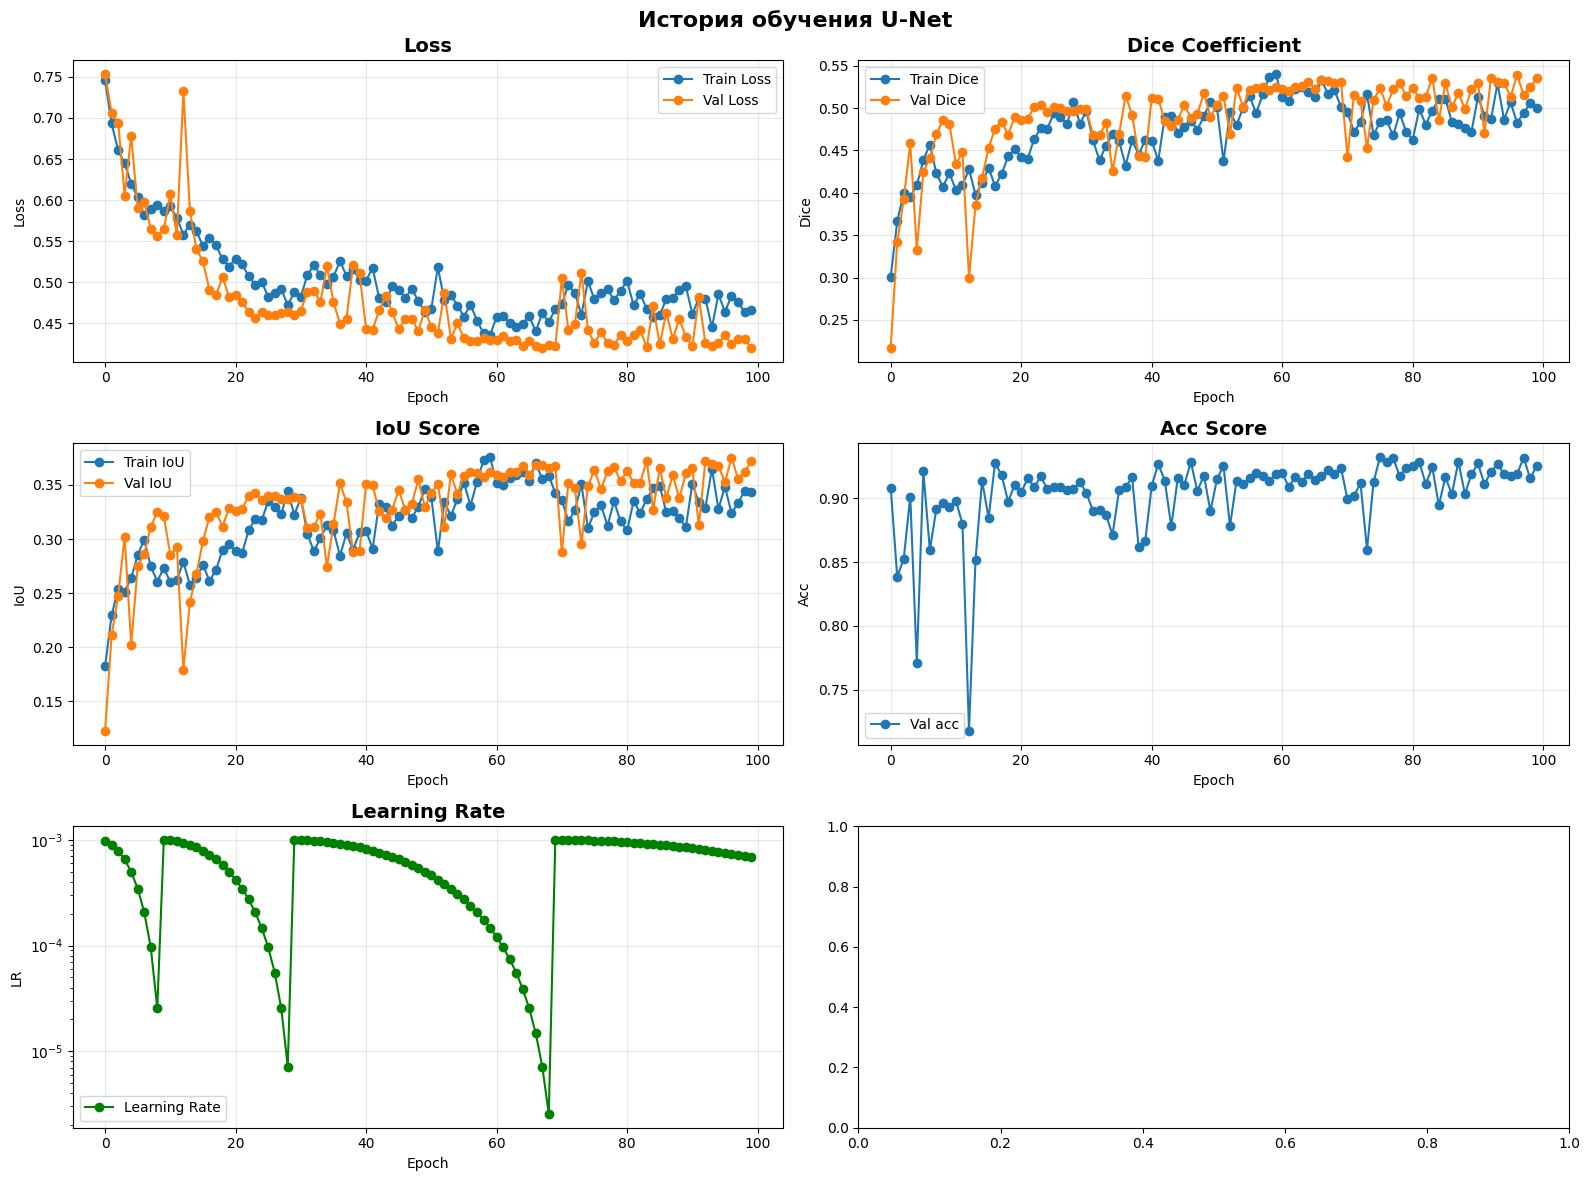

Train Loss: 0.4661
Val Loss: 0.4198
Train Dice: 0.5001
Val Dice: 0.5351
Train IoU: 0.3432
Val IoU: 0.3719
Val Accuracy: 0.9252


In [34]:
def plot_training_history(history):

    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='o')
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # IoU Score
    axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o')
    axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='o')
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Acc Score
    axes[1, 1].plot(history['val_acc'], label='Val acc', marker='o')
    axes[1, 1].set_title('Acc Score', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Acc')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[2, 0].plot(history['lr'], label='Learning Rate', marker='o', color='green')
    axes[2, 0].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[2, 0].set_xlabel('Epoch')
    axes[2, 0].set_ylabel('LR')
    axes[2, 0].set_yscale('log')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    plt.suptitle('История обучения U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Train Dice: {history['train_dice'][-1]:.4f}")
    print(f"Val Dice: {history['val_dice'][-1]:.4f}")
    print(f"Train IoU: {history['train_iou'][-1]:.4f}")
    print(f"Val IoU: {history['val_iou'][-1]:.4f}")
    print(f"Val Accuracy: {history['val_acc'][-1]:.4f}")

plot_training_history(history)

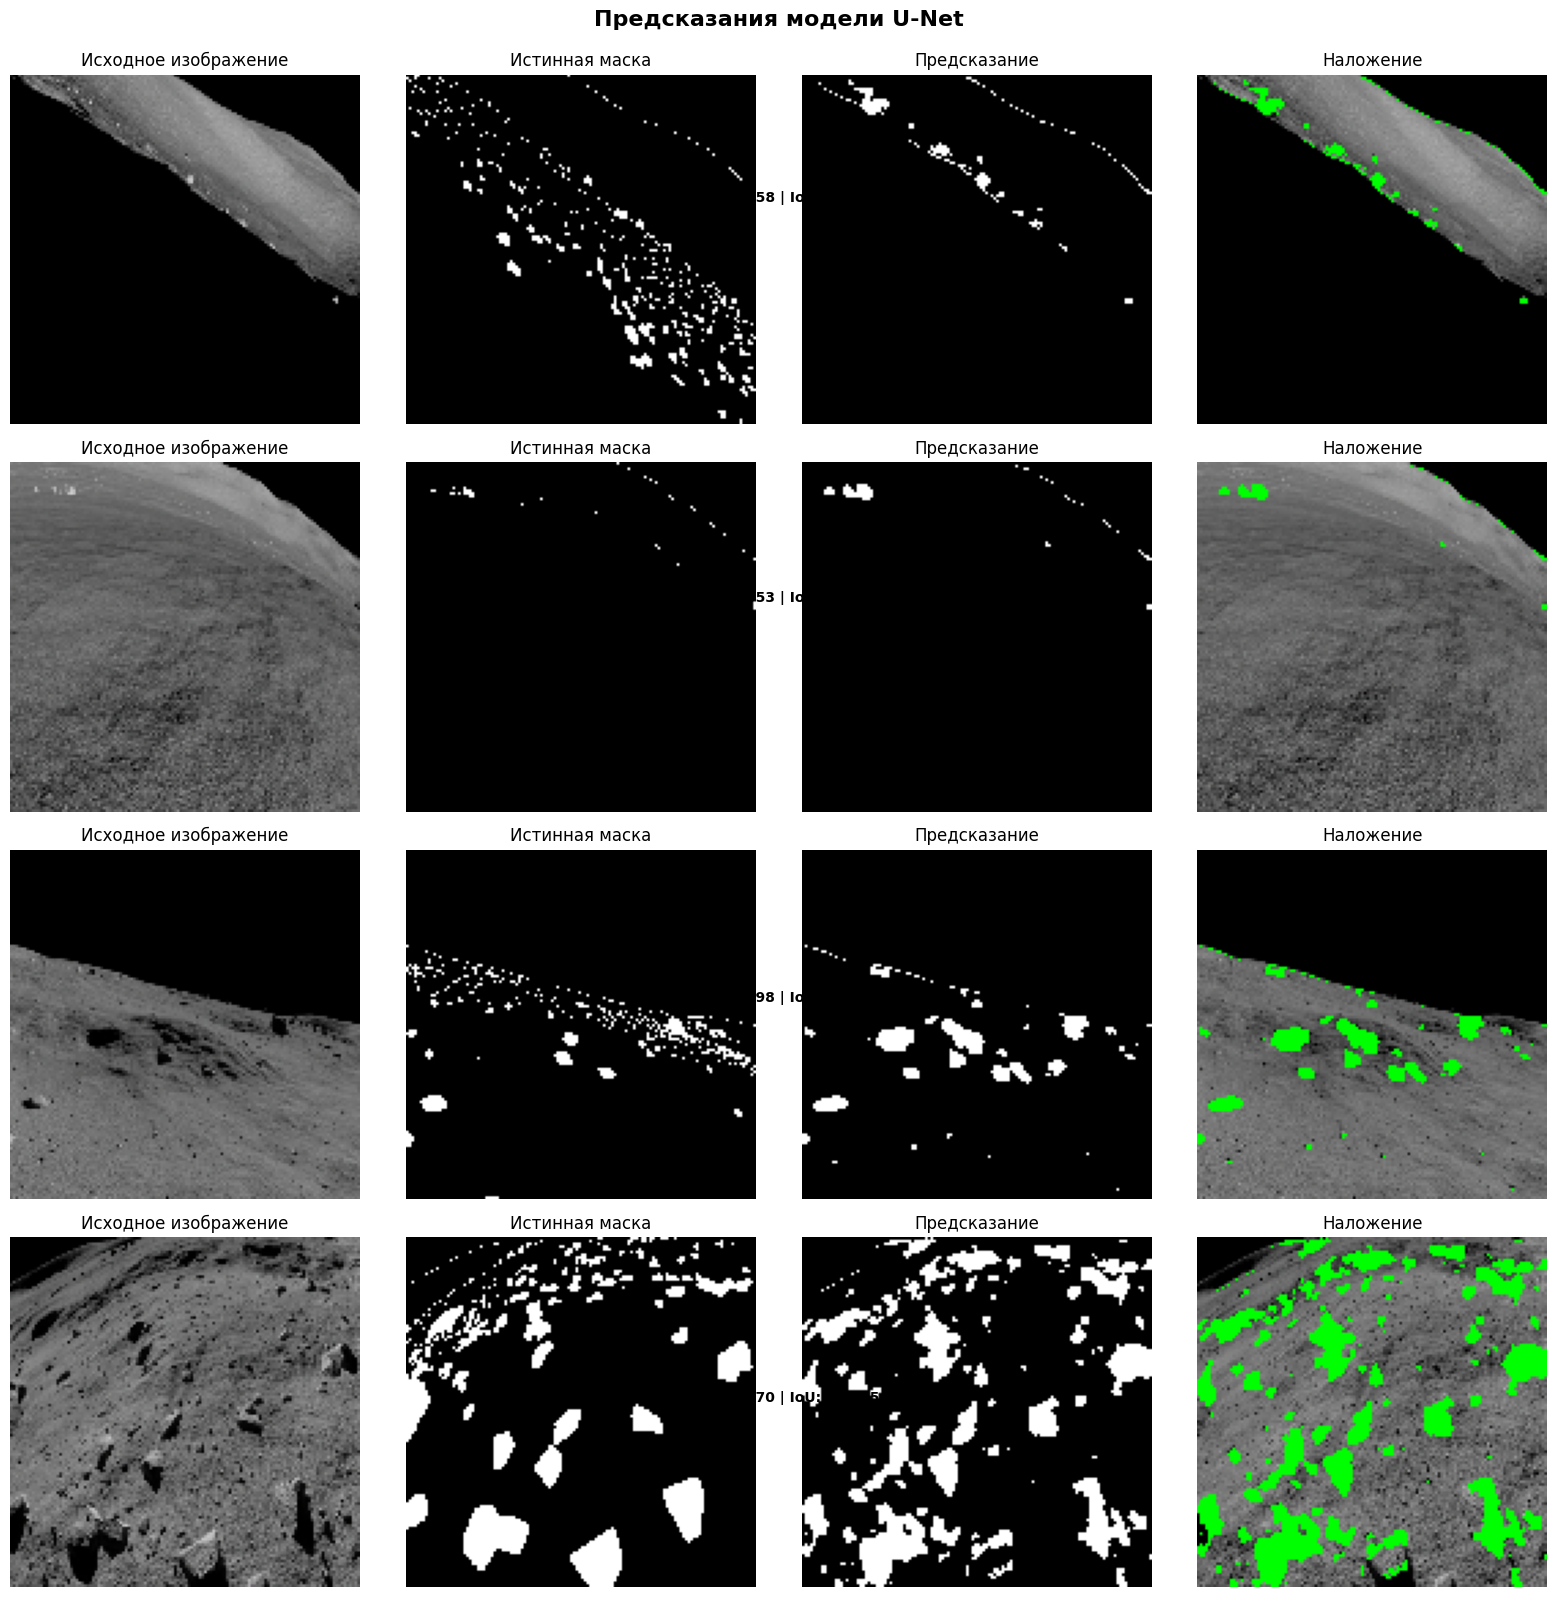

In [35]:
def visualize_predictions(model, dataloader, device, num_samples=4):

    model.eval()
    
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        outputs = model(images).cpu()
        predictions = torch.sigmoid(outputs)
        predictions = (predictions > 0.5).float()
    
    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :,:].numpy()
        mask_pred = predictions[i, 0].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')
        
        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')
        
        dice = dice_coefficient(outputs[i:i+1], masks[i:i+1])
        iou = iou_score(outputs[i:i+1], masks[i:i+1])
        
        fig.text(0.5, 1 - (i + 0.5) / num_samples, 
                f'Dice: {dice:.4f} | IoU: {iou:.4f}',
                ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, device, num_samples=4)

# Тестирование лучшей модели

Параметров: 2,556,241
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
Эпоха: 97
Val Dice: 0.5393
Val IoU: 0.3752
Val Accuracy: 0.9192


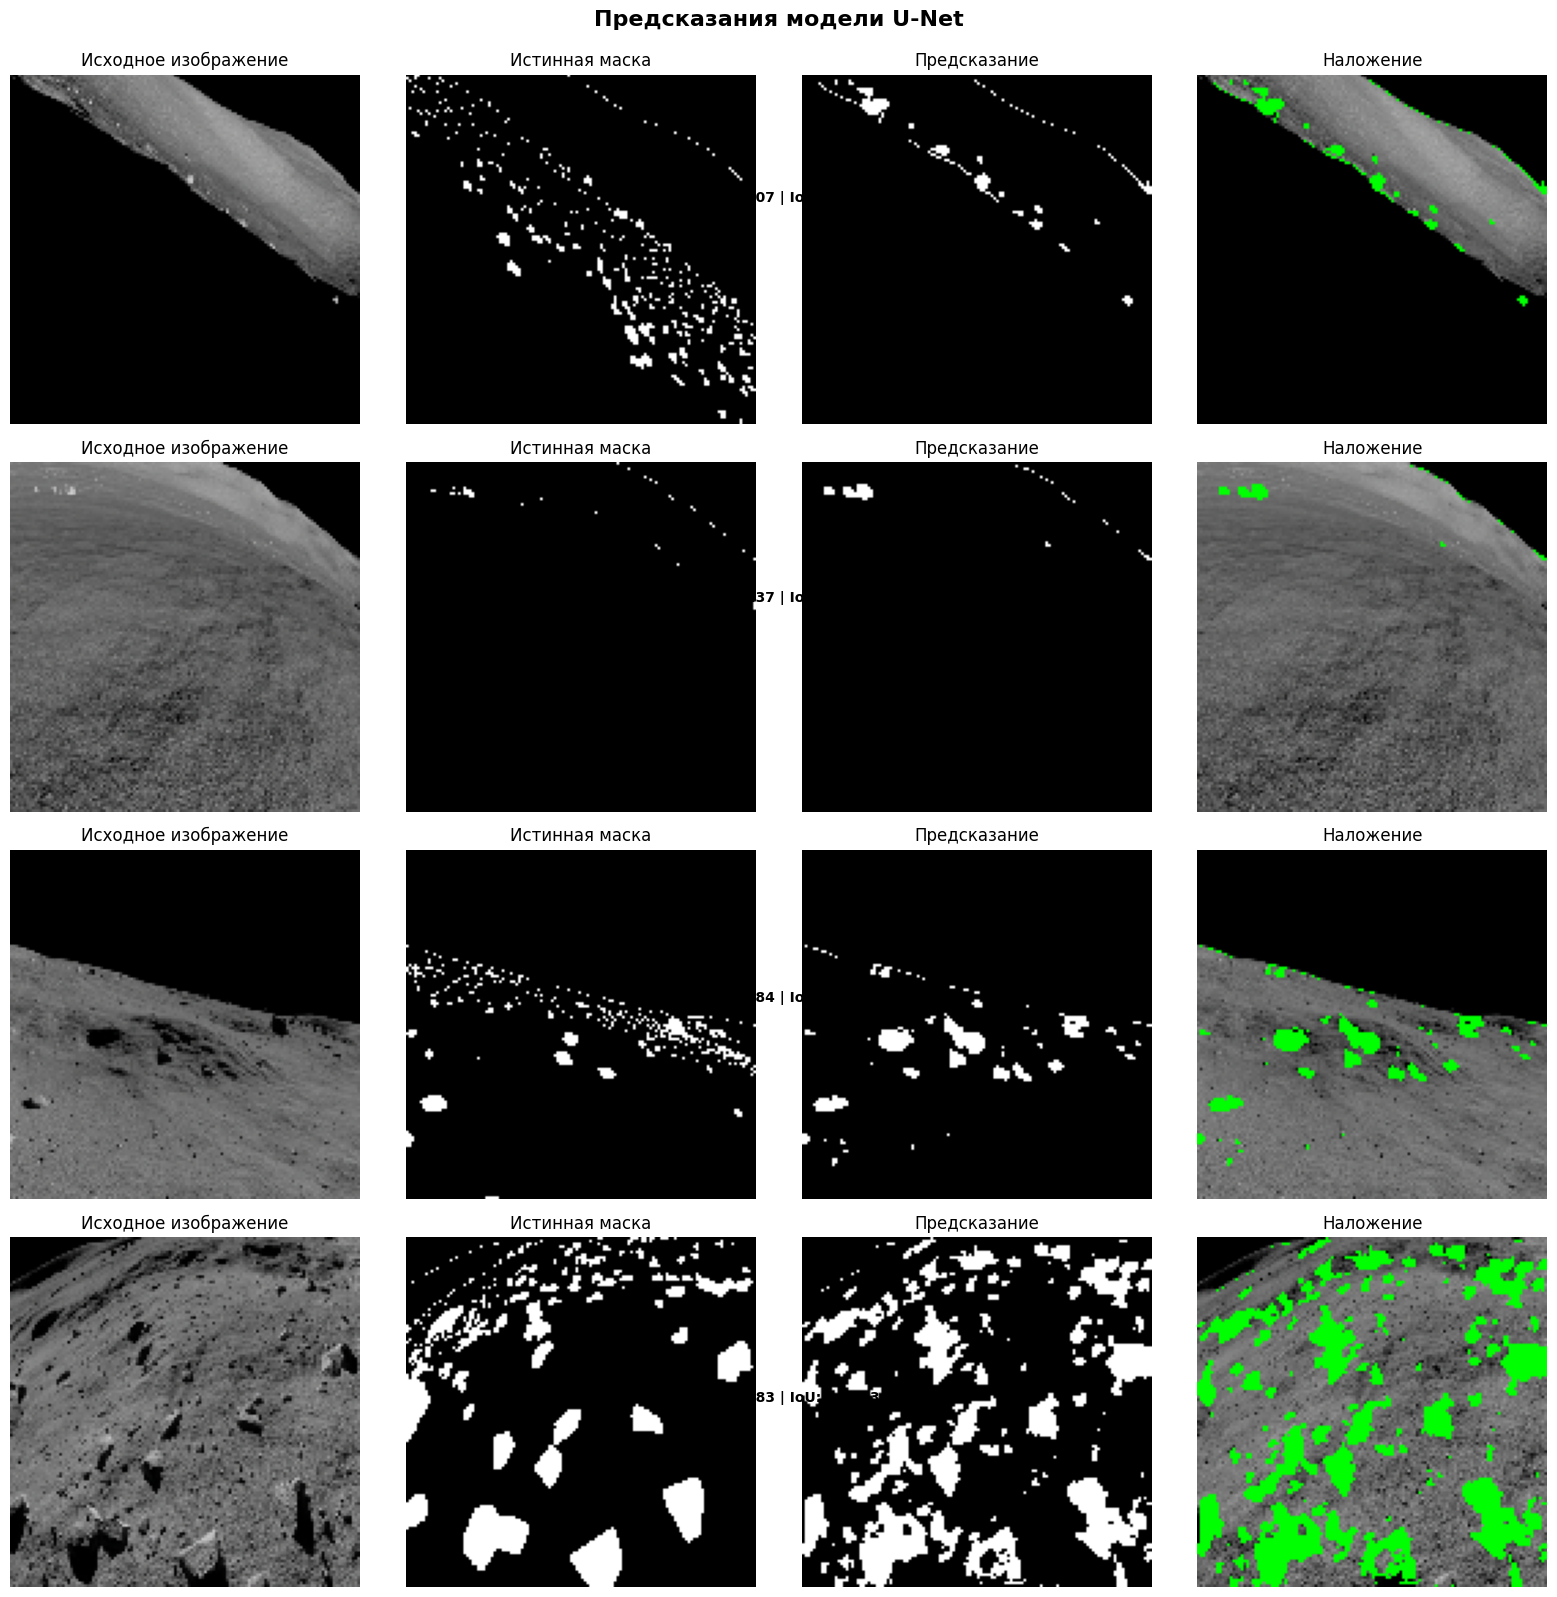

In [ ]:
best_model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])

checkpoint_unet = torch.load('best_moon_unet.pth', map_location=device)
best_model.load_state_dict(checkpoint_unet['model_state_dict'])
best_model = best_model.to(device)

print(f"Эпоха: {checkpoint_unet['epoch'] + 1}")
print(f"Val Dice: {checkpoint_unet['val_dice']:.4f}")
print(f"Val IoU: {checkpoint_unet['val_iou']:.4f}")
print(f"Val Accuracy: {checkpoint_unet['val_acc']:.4f}")

visualize_predictions(best_model, val_loader, device, num_samples=4)

# Часть 3. U-Net с бэкбоном из классификатора

1) Вариант A (заморозка): заморозить веса энкодера, обучать только декодер.
2) Вариант B (тонкая настройка): полностью разморозить энкодер на поздних этапах. В данном случае разморожены 2 последних блока.

Количество стадий совпадает, поэтому просто беру блоки для энкодера

In [ ]:
class MyNNUNetFreeze(nn.Module):

    def __init__(self, out_channels=1, freeze_all=False):
        super(MyNNUNetFreeze, self).__init__()

        # Загружаем предобученную модель классификартора
        model_final_test = MyNNImageNetTiny(20)

        checkpoint = torch.load('best_model_classifire.pth', map_location=device)
        model_final_test.load_state_dict(checkpoint)
        
        # Извлекаем слои энкодера
        self.encoder1 = nn.Sequential(
            model_final_test.conv0,      # 32 канала
            model_final_test.bn0,
            model_final_test.relu
        )

        self.encoder2 = nn.Sequential(  # 32 канала, stride=2
            model_final_test.block1,
            model_final_test.bn1
        )
        self.encoder3 = nn.Sequential(  # 64 канала, stride=2
            model_final_test.block2,
            model_final_test.bn2
        ) 
        self.encoder4 = nn.Sequential(  # 128 каналов, stride=2
            model_final_test.block3,
            model_final_test.bn3
        )
        self.encoder5 = nn.Sequential(  # 256 каналов, stride=2
            model_final_test.block4,
            model_final_test.bn4
        )

        encoders = [self.encoder1, self.encoder2, self.encoder3, self.encoder4, self.encoder5]
        if (freeze_all):
            for enc in encoders:
                for param in enc.parameters():
                    param.requires_grad = False
        else:
            for enc in encoders[0:3]:
                for param in enc.parameters():
                    param.requires_grad = False
        
        # Decoder блок 1 (256 -> 128)
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(128 + 128, 128)  # Concat с encoder4
        
        # Decoder блок 2 (128 -> 64)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(64 + 64, 64)  # Concat с encoder3
        
        # Decoder блок 3 (64 -> 32)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(32 + 32, 32)  # Concat с encoder2
        
        # Decoder блок 4 (32 -> 32)
        self.upconv1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(32 + 32, 32)  # Concat с encoder1

        # Выходной слой
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)
    
    def forward(self, x):

        # Исходный размер: [B, 3, H, W]
        
        enc1 = self.encoder1(x)      # [B, 32, H, W]
        
        enc2 = self.encoder2(enc1)  # [B, 32, H/2, W/2]
        enc3 = self.encoder3(enc2)         # [B, 64, H/4, W/4]
        enc4 = self.encoder4(enc3)         # [B, 128, H/8, W/8]
        enc5 = self.encoder5(enc4)         # [B, 256, H/16, W/16]
        
        # Decoder блок 1
        dec4 = self.upconv4(enc5)           # [B, 128, H/8, W/8]
        dec4 = torch.cat([dec4, enc4], dim=1)  # [B, 256, H/8, W/8]
        dec4 = self.decoder4(dec4)          # [B, 128, H/8, W/8]
        
        # Decoder блок 2
        dec3 = self.upconv3(dec4)           # [B, 32, H/4, W/4]
        dec3 = torch.cat([dec3, enc3], dim=1)  # [B, 64, H/4, W/4]
        dec3 = self.decoder3(dec3)          # [B, 32, H/4, W/4]
        
        # Decoder блок 3
        dec2 = self.upconv2(dec3)           # [B, 32, H/2, W/2]
        dec2 = torch.cat([dec2, enc2], dim=1)  # [B, 64, H/2, W/2]
        dec2 = self.decoder2(dec2)          # [B, 32, H/2, W/2]
        
        # Decoder блок 4
        dec1 = self.upconv1(dec2)           # [B, 32, H, W]
        dec1 = torch.cat([dec1, enc1], dim=1)  # [B, 64, H, W]
        dec1 = self.decoder1(dec1)          # [B, 32, H, W]
        
        # Выходной слой
        out = self.out_conv(dec1)          # [B, 1, H, W]
        
        return out


my_unet_freeze = MyNNUNetFreeze(out_channels=1)

test_input = torch.randn(1, 3, 128, 128)
test_output = my_unet_freeze(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

total_params = sum(p.numel() for p in my_unet_freeze.parameters())
trainable_params = sum(p.numel() for p in my_unet_freeze.parameters() if p.requires_grad)

print(f"   Всего параметров: {total_params:,}")
print(f"   Обучаемых параметров: {trainable_params:,}")

   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])
   Всего параметров: 4,092,173
   Обучаемых параметров: 3,832,999


## Обучение варианта А (энкодер полностью заморожен)

In [39]:
my_model_freeze_all = MyNNUNetFreeze(out_channels=1, freeze_all=True)

my_model_criterion = CombinedLoss(bce_weight=0.3, dice_weight=0.7)


encoder_params = []
decoder_params = []

for name, param in my_model_freeze_all.named_parameters():
    if 'encoder' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

my_optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': 1e-4},  # Меньший LR для предобученных слоев
    {'params': decoder_params, 'lr': 1e-3}   # Обычный LR для новых слоев
])

my_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    my_optimizer,
    T_0=10,        # ← каждые 10 эпох — рестарт
    T_mult=2,      # ← следующий цикл в 2× длиннее
    eta_min=1e-6   # ← минимальный LR
)

NUM_EPOCHS = 100
SAVE_PATH_FREEZE_ALL = 'best_my_unet_freeze_all.pth'

print(f"   Эпох: {NUM_EPOCHS}")
print(f"   Encoder LR: 1e-4 (fine-tuning)")
print(f"   Decoder LR: 1e-3")
print(f"   Модель будет сохранена в: {SAVE_PATH_FREEZE_ALL}")

my_history_freeze_all = train_model(
    model=my_model_freeze_all,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=my_model_criterion,
    optimizer=my_optimizer,
    scheduler=my_scheduler,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_path=SAVE_PATH_FREEZE_ALL
)

   Эпох: 100
   Encoder LR: 1e-4 (fine-tuning)
   Decoder LR: 1e-3
   Модель будет сохранена в: best_my_unet_freeze_all.pth
Эпоха 1/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s, loss=0.7496, dice=0.3264, iou=0.1950, acc=0.5791]



 Результаты эпохи 1:
  Train - Loss: 0.7728, Dice: 0.2770, IoU: 0.1678
  Val   - Loss: 0.7870, Dice: 0.2605, IoU: 0.1510, Acc: 0.5611
  LR: 0.000098
  Сохранена лучшая модель! Dice: 0.2605
Эпоха 2/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 28.70it/s, loss=0.6708, dice=0.4034, iou=0.2527, acc=0.7227]



 Результаты эпохи 2:
  Train - Loss: 0.7226, Dice: 0.3371, IoU: 0.2099
  Val   - Loss: 0.7124, Dice: 0.3307, IoU: 0.2002, Acc: 0.7299
  LR: 0.000091
  Сохранена лучшая модель! Dice: 0.3307
Эпоха 3/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.74it/s, loss=0.6173, dice=0.4729, iou=0.3097, acc=0.8383]



 Результаты эпохи 3:
  Train - Loss: 0.6846, Dice: 0.3871, IoU: 0.2471
  Val   - Loss: 0.6553, Dice: 0.4038, IoU: 0.2578, Acc: 0.8499
  LR: 0.000080
  Сохранена лучшая модель! Dice: 0.4038
Эпоха 4/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.56it/s, loss=0.5726, dice=0.5217, iou=0.3529, acc=0.8799]



 Результаты эпохи 4:
  Train - Loss: 0.6506, Dice: 0.4190, IoU: 0.2711
  Val   - Loss: 0.6201, Dice: 0.4231, IoU: 0.2737, Acc: 0.8747
  LR: 0.000066
  Сохранена лучшая модель! Dice: 0.4231
Эпоха 5/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.29it/s, loss=0.5928, dice=0.4845, iou=0.3197, acc=0.8213]



 Результаты эпохи 5:
  Train - Loss: 0.6349, Dice: 0.4104, IoU: 0.2667
  Val   - Loss: 0.6369, Dice: 0.4042, IoU: 0.2571, Acc: 0.8266
  LR: 0.000051
Эпоха 6/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.36it/s, loss=0.5476, dice=0.5463, iou=0.3758, acc=0.8850]



 Результаты эпохи 6:
  Train - Loss: 0.6171, Dice: 0.4214, IoU: 0.2764
  Val   - Loss: 0.5944, Dice: 0.4525, IoU: 0.2990, Acc: 0.8815
  LR: 0.000035
  Сохранена лучшая модель! Dice: 0.4525
Эпоха 7/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.80it/s, loss=0.5375, dice=0.5529, iou=0.3821, acc=0.8934]



 Результаты эпохи 7:
  Train - Loss: 0.5971, Dice: 0.4425, IoU: 0.2927
  Val   - Loss: 0.5840, Dice: 0.4650, IoU: 0.3076, Acc: 0.8883
  LR: 0.000021
  Сохранена лучшая модель! Dice: 0.4650
Эпоха 8/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.93it/s, loss=0.5303, dice=0.5541, iou=0.3832, acc=0.9012]



 Результаты эпохи 8:
  Train - Loss: 0.5751, Dice: 0.4745, IoU: 0.3158
  Val   - Loss: 0.5763, Dice: 0.4726, IoU: 0.3145, Acc: 0.9002
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.4726
Эпоха 9/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.65it/s, loss=0.5282, dice=0.5521, iou=0.3813, acc=0.9003]



 Результаты эпохи 9:
  Train - Loss: 0.5822, Dice: 0.4568, IoU: 0.3022
  Val   - Loss: 0.5735, Dice: 0.4753, IoU: 0.3167, Acc: 0.9025
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.4753
Эпоха 10/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.80it/s, loss=0.5232, dice=0.5533, iou=0.3824, acc=0.8976]



 Результаты эпохи 10:
  Train - Loss: 0.5918, Dice: 0.4331, IoU: 0.2844
  Val   - Loss: 0.5696, Dice: 0.4771, IoU: 0.3186, Acc: 0.9001
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4771
Эпоха 11/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.07it/s, loss=0.4874, dice=0.5879, iou=0.4164, acc=0.9085]



 Результаты эпохи 11:
  Train - Loss: 0.5661, Dice: 0.4702, IoU: 0.3152
  Val   - Loss: 0.5431, Dice: 0.5014, IoU: 0.3392, Acc: 0.9062
  LR: 0.000099
  Сохранена лучшая модель! Dice: 0.5014
Эпоха 12/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.01it/s, loss=0.4823, dice=0.5416, iou=0.3714, acc=0.8815]



 Результаты эпохи 12:
  Train - Loss: 0.5363, Dice: 0.4787, IoU: 0.3223
  Val   - Loss: 0.5469, Dice: 0.4520, IoU: 0.2962, Acc: 0.8745
  LR: 0.000098
Эпоха 13/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s, loss=0.4710, dice=0.5538, iou=0.3829, acc=0.8935]



 Результаты эпохи 13:
  Train - Loss: 0.5368, Dice: 0.4640, IoU: 0.3051
  Val   - Loss: 0.5201, Dice: 0.4813, IoU: 0.3223, Acc: 0.8990
  LR: 0.000095
Эпоха 14/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.02it/s, loss=0.4530, dice=0.5503, iou=0.3796, acc=0.9050]



 Результаты эпохи 14:
  Train - Loss: 0.5289, Dice: 0.4588, IoU: 0.3063
  Val   - Loss: 0.4988, Dice: 0.4801, IoU: 0.3216, Acc: 0.9129
  LR: 0.000091
Эпоха 15/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.99it/s, loss=0.4362, dice=0.5681, iou=0.3968, acc=0.9033]



 Результаты эпохи 15:
  Train - Loss: 0.5179, Dice: 0.4670, IoU: 0.3089
  Val   - Loss: 0.4834, Dice: 0.4959, IoU: 0.3345, Acc: 0.9051
  LR: 0.000086
Эпоха 16/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.61it/s, loss=0.4449, dice=0.5469, iou=0.3764, acc=0.9129]



 Результаты эпохи 16:
  Train - Loss: 0.5055, Dice: 0.4799, IoU: 0.3208
  Val   - Loss: 0.4833, Dice: 0.4861, IoU: 0.3270, Acc: 0.9190
  LR: 0.000080
Эпоха 17/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 29.20it/s, loss=0.4404, dice=0.5475, iou=0.3769, acc=0.9120]



 Результаты эпохи 17:
  Train - Loss: 0.5016, Dice: 0.4739, IoU: 0.3160
  Val   - Loss: 0.4836, Dice: 0.4729, IoU: 0.3181, Acc: 0.9237
  LR: 0.000073
Эпоха 18/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.79it/s, loss=0.4370, dice=0.5470, iou=0.3765, acc=0.9069]



 Результаты эпохи 18:
  Train - Loss: 0.5091, Dice: 0.4661, IoU: 0.3081
  Val   - Loss: 0.4874, Dice: 0.4696, IoU: 0.3123, Acc: 0.9168
  LR: 0.000066
Эпоха 19/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.91it/s, loss=0.4259, dice=0.5567, iou=0.3857, acc=0.9009]



 Результаты эпохи 19:
  Train - Loss: 0.4892, Dice: 0.4864, IoU: 0.3273
  Val   - Loss: 0.4749, Dice: 0.4796, IoU: 0.3203, Acc: 0.9114
  LR: 0.000058
Эпоха 20/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.88it/s, loss=0.4518, dice=0.5360, iou=0.3661, acc=0.8722]



 Результаты эпохи 20:
  Train - Loss: 0.4972, Dice: 0.4728, IoU: 0.3179
  Val   - Loss: 0.4970, Dice: 0.4676, IoU: 0.3097, Acc: 0.8839
  LR: 0.000051
Эпоха 21/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.82it/s, loss=0.4481, dice=0.5394, iou=0.3693, acc=0.8760]



 Результаты эпохи 21:
  Train - Loss: 0.5168, Dice: 0.4527, IoU: 0.2991
  Val   - Loss: 0.4834, Dice: 0.4788, IoU: 0.3195, Acc: 0.8977
  LR: 0.000043
Эпоха 22/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.94it/s, loss=0.4197, dice=0.5654, iou=0.3941, acc=0.9049]



 Результаты эпохи 22:
  Train - Loss: 0.4900, Dice: 0.4818, IoU: 0.3233
  Val   - Loss: 0.4613, Dice: 0.4940, IoU: 0.3341, Acc: 0.9180
  LR: 0.000035
Эпоха 23/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.97it/s, loss=0.4082, dice=0.5781, iou=0.4066, acc=0.9020]



 Результаты эпохи 23:
  Train - Loss: 0.4753, Dice: 0.5020, IoU: 0.3422
  Val   - Loss: 0.4620, Dice: 0.4995, IoU: 0.3396, Acc: 0.9095
  LR: 0.000028
Эпоха 24/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.87it/s, loss=0.4124, dice=0.5725, iou=0.4011, acc=0.9016]



 Результаты эпохи 24:
  Train - Loss: 0.4697, Dice: 0.5075, IoU: 0.3485
  Val   - Loss: 0.4579, Dice: 0.5041, IoU: 0.3429, Acc: 0.9124
  LR: 0.000021
  Сохранена лучшая модель! Dice: 0.5041
Эпоха 25/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.15it/s, loss=0.4120, dice=0.5746, iou=0.4031, acc=0.8988]



 Результаты эпохи 25:
  Train - Loss: 0.4768, Dice: 0.4976, IoU: 0.3393
  Val   - Loss: 0.4532, Dice: 0.5099, IoU: 0.3476, Acc: 0.9111
  LR: 0.000015
  Сохранена лучшая модель! Dice: 0.5099
Эпоха 26/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.49it/s, loss=0.4198, dice=0.5667, iou=0.3954, acc=0.8950]



 Результаты эпохи 26:
  Train - Loss: 0.4846, Dice: 0.4897, IoU: 0.3303
  Val   - Loss: 0.4542, Dice: 0.5089, IoU: 0.3469, Acc: 0.9115
  LR: 0.000010
Эпоха 27/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.43it/s, loss=0.4138, dice=0.5722, iou=0.4007, acc=0.8960]



 Результаты эпохи 27:
  Train - Loss: 0.4740, Dice: 0.5012, IoU: 0.3366
  Val   - Loss: 0.4563, Dice: 0.5053, IoU: 0.3439, Acc: 0.9104
  LR: 0.000006
Эпоха 28/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.42it/s, loss=0.4193, dice=0.5659, iou=0.3946, acc=0.8969]



 Результаты эпохи 28:
  Train - Loss: 0.4960, Dice: 0.4707, IoU: 0.3157
  Val   - Loss: 0.4543, Dice: 0.5035, IoU: 0.3423, Acc: 0.9140
  LR: 0.000003
Эпоха 29/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.54it/s, loss=0.4131, dice=0.5719, iou=0.4004, acc=0.8990]



 Результаты эпохи 29:
  Train - Loss: 0.4682, Dice: 0.5090, IoU: 0.3470
  Val   - Loss: 0.4525, Dice: 0.5053, IoU: 0.3446, Acc: 0.9138
  LR: 0.000002
Эпоха 30/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 28.74it/s, loss=0.4180, dice=0.5692, iou=0.3979, acc=0.8991]



 Результаты эпохи 30:
  Train - Loss: 0.4812, Dice: 0.4896, IoU: 0.3304
  Val   - Loss: 0.4543, Dice: 0.5054, IoU: 0.3443, Acc: 0.9139
  LR: 0.000100
Эпоха 31/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.09it/s, loss=0.4291, dice=0.5516, iou=0.3808, acc=0.8929]



 Результаты эпохи 31:
  Train - Loss: 0.4699, Dice: 0.5049, IoU: 0.3417
  Val   - Loss: 0.4751, Dice: 0.4827, IoU: 0.3246, Acc: 0.9044
  LR: 0.000100
Эпоха 32/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.62it/s, loss=0.3948, dice=0.5797, iou=0.4081, acc=0.9114]



 Результаты эпохи 32:
  Train - Loss: 0.5043, Dice: 0.4638, IoU: 0.3076
  Val   - Loss: 0.4489, Dice: 0.5009, IoU: 0.3390, Acc: 0.9192
  LR: 0.000099
Эпоха 33/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.11it/s, loss=0.4058, dice=0.5733, iou=0.4019, acc=0.9011]



 Результаты эпохи 33:
  Train - Loss: 0.4953, Dice: 0.4742, IoU: 0.3149
  Val   - Loss: 0.4494, Dice: 0.5079, IoU: 0.3467, Acc: 0.9138
  LR: 0.000099
Эпоха 34/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.21it/s, loss=0.4270, dice=0.5438, iou=0.3734, acc=0.9091]



 Результаты эпохи 34:
  Train - Loss: 0.4820, Dice: 0.4890, IoU: 0.3288
  Val   - Loss: 0.4644, Dice: 0.4830, IoU: 0.3230, Acc: 0.9175
  LR: 0.000098
Эпоха 35/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.09it/s, loss=0.5082, dice=0.4932, iou=0.3273, acc=0.8406]



 Результаты эпохи 35:
  Train - Loss: 0.4651, Dice: 0.5079, IoU: 0.3466
  Val   - Loss: 0.5397, Dice: 0.4220, IoU: 0.2732, Acc: 0.8543
  LR: 0.000096
Эпоха 36/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 29.36it/s, loss=0.4314, dice=0.5345, iou=0.3647, acc=0.9117]



 Результаты эпохи 36:
  Train - Loss: 0.5029, Dice: 0.4559, IoU: 0.3057
  Val   - Loss: 0.4771, Dice: 0.4623, IoU: 0.3063, Acc: 0.9166
  LR: 0.000095
Эпоха 37/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.91it/s, loss=0.4223, dice=0.5518, iou=0.3810, acc=0.8975]



 Результаты эпохи 37:
  Train - Loss: 0.4739, Dice: 0.4950, IoU: 0.3331
  Val   - Loss: 0.4710, Dice: 0.4921, IoU: 0.3302, Acc: 0.8974
  LR: 0.000093
Эпоха 38/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s, loss=0.4082, dice=0.5622, iou=0.3910, acc=0.8970]



 Результаты эпохи 38:
  Train - Loss: 0.4901, Dice: 0.4757, IoU: 0.3212
  Val   - Loss: 0.4576, Dice: 0.4937, IoU: 0.3323, Acc: 0.9016
  LR: 0.000091
Эпоха 39/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.76it/s, loss=0.4150, dice=0.5638, iou=0.3926, acc=0.8946]



 Результаты эпохи 39:
  Train - Loss: 0.5122, Dice: 0.4444, IoU: 0.2916
  Val   - Loss: 0.4614, Dice: 0.4936, IoU: 0.3340, Acc: 0.9035
  LR: 0.000088
Эпоха 40/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.77it/s, loss=0.4102, dice=0.5663, iou=0.3950, acc=0.8878]



 Результаты эпохи 40:
  Train - Loss: 0.5106, Dice: 0.4526, IoU: 0.3018
  Val   - Loss: 0.4545, Dice: 0.4958, IoU: 0.3343, Acc: 0.9020
  LR: 0.000086
Эпоха 41/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.70it/s, loss=0.4092, dice=0.5649, iou=0.3937, acc=0.9024]



 Результаты эпохи 41:
  Train - Loss: 0.5117, Dice: 0.4463, IoU: 0.2927
  Val   - Loss: 0.4692, Dice: 0.4778, IoU: 0.3204, Acc: 0.9019
  LR: 0.000083
Эпоха 42/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.07it/s, loss=0.4073, dice=0.5622, iou=0.3910, acc=0.9099]



 Результаты эпохи 42:
  Train - Loss: 0.4863, Dice: 0.4789, IoU: 0.3195
  Val   - Loss: 0.4478, Dice: 0.4987, IoU: 0.3367, Acc: 0.9196
  LR: 0.000080
Эпоха 43/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.75it/s, loss=0.4022, dice=0.5726, iou=0.4011, acc=0.9118]



 Результаты эпохи 43:
  Train - Loss: 0.4701, Dice: 0.5053, IoU: 0.3415
  Val   - Loss: 0.4483, Dice: 0.5022, IoU: 0.3417, Acc: 0.9167
  LR: 0.000076
Эпоха 44/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.75it/s, loss=0.3942, dice=0.5899, iou=0.4183, acc=0.9040]



 Результаты эпохи 44:
  Train - Loss: 0.4844, Dice: 0.4824, IoU: 0.3249
  Val   - Loss: 0.4475, Dice: 0.5074, IoU: 0.3473, Acc: 0.9126
  LR: 0.000073
Эпоха 45/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.86it/s, loss=0.4000, dice=0.5730, iou=0.4015, acc=0.9115]



 Результаты эпохи 45:
  Train - Loss: 0.4804, Dice: 0.4900, IoU: 0.3312
  Val   - Loss: 0.4407, Dice: 0.5107, IoU: 0.3491, Acc: 0.9213
  LR: 0.000069
  Сохранена лучшая модель! Dice: 0.5107
Эпоха 46/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.08it/s, loss=0.3914, dice=0.5814, iou=0.4098, acc=0.9157]



 Результаты эпохи 46:
  Train - Loss: 0.4657, Dice: 0.5092, IoU: 0.3450
  Val   - Loss: 0.4358, Dice: 0.5130, IoU: 0.3511, Acc: 0.9238
  LR: 0.000066
  Сохранена лучшая модель! Dice: 0.5130
Эпоха 47/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.27it/s, loss=0.4006, dice=0.5703, iou=0.3989, acc=0.9109]



 Результаты эпохи 47:
  Train - Loss: 0.4688, Dice: 0.5043, IoU: 0.3416
  Val   - Loss: 0.4468, Dice: 0.5006, IoU: 0.3404, Acc: 0.9182
  LR: 0.000062
Эпоха 48/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.56it/s, loss=0.4152, dice=0.5590, iou=0.3879, acc=0.8995]



 Результаты эпохи 48:
  Train - Loss: 0.4730, Dice: 0.4975, IoU: 0.3386
  Val   - Loss: 0.4605, Dice: 0.4896, IoU: 0.3297, Acc: 0.9088
  LR: 0.000058
Эпоха 49/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.50it/s, loss=0.3905, dice=0.5867, iou=0.4151, acc=0.9104]



 Результаты эпохи 49:
  Train - Loss: 0.4664, Dice: 0.5054, IoU: 0.3446
  Val   - Loss: 0.4373, Dice: 0.5146, IoU: 0.3532, Acc: 0.9179
  LR: 0.000054
  Сохранена лучшая модель! Dice: 0.5146
Эпоха 50/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.80it/s, loss=0.3865, dice=0.5910, iou=0.4194, acc=0.9119]



 Результаты эпохи 50:
  Train - Loss: 0.4592, Dice: 0.5059, IoU: 0.3440
  Val   - Loss: 0.4391, Dice: 0.5168, IoU: 0.3561, Acc: 0.9195
  LR: 0.000051
  Сохранена лучшая модель! Dice: 0.5168
Эпоха 51/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.12it/s, loss=0.4018, dice=0.5724, iou=0.4009, acc=0.9146]



 Результаты эпохи 51:
  Train - Loss: 0.4704, Dice: 0.4950, IoU: 0.3347
  Val   - Loss: 0.4459, Dice: 0.5075, IoU: 0.3467, Acc: 0.9211
  LR: 0.000047
Эпоха 52/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.64it/s, loss=0.3943, dice=0.5812, iou=0.4096, acc=0.9120]



 Результаты эпохи 52:
  Train - Loss: 0.4738, Dice: 0.4953, IoU: 0.3340
  Val   - Loss: 0.4409, Dice: 0.5162, IoU: 0.3543, Acc: 0.9173
  LR: 0.000043
Эпоха 53/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.16it/s, loss=0.3872, dice=0.5875, iou=0.4159, acc=0.9165]



 Результаты эпохи 53:
  Train - Loss: 0.4577, Dice: 0.5160, IoU: 0.3521
  Val   - Loss: 0.4306, Dice: 0.5223, IoU: 0.3605, Acc: 0.9245
  LR: 0.000039
  Сохранена лучшая модель! Dice: 0.5223
Эпоха 54/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.94it/s, loss=0.3901, dice=0.5811, iou=0.4095, acc=0.9111]



 Результаты эпохи 54:
  Train - Loss: 0.4610, Dice: 0.5071, IoU: 0.3450
  Val   - Loss: 0.4308, Dice: 0.5211, IoU: 0.3587, Acc: 0.9227
  LR: 0.000035
Эпоха 55/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.13it/s, loss=0.3951, dice=0.5838, iou=0.4122, acc=0.8981]



 Результаты эпохи 55:
  Train - Loss: 0.4545, Dice: 0.5175, IoU: 0.3531
  Val   - Loss: 0.4456, Dice: 0.5074, IoU: 0.3457, Acc: 0.9094
  LR: 0.000032
Эпоха 56/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.70it/s, loss=0.3844, dice=0.5902, iou=0.4186, acc=0.9073]



 Результаты эпохи 56:
  Train - Loss: 0.4613, Dice: 0.5031, IoU: 0.3428
  Val   - Loss: 0.4347, Dice: 0.5204, IoU: 0.3577, Acc: 0.9167
  LR: 0.000028
Эпоха 57/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s, loss=0.3887, dice=0.5866, iou=0.4150, acc=0.9062]



 Результаты эпохи 57:
  Train - Loss: 0.4393, Dice: 0.5292, IoU: 0.3662
  Val   - Loss: 0.4384, Dice: 0.5155, IoU: 0.3532, Acc: 0.9130
  LR: 0.000025
Эпоха 58/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s, loss=0.3912, dice=0.5825, iou=0.4109, acc=0.9065]



 Результаты эпохи 58:
  Train - Loss: 0.4715, Dice: 0.4911, IoU: 0.3332
  Val   - Loss: 0.4373, Dice: 0.5177, IoU: 0.3547, Acc: 0.9152
  LR: 0.000021
Эпоха 59/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.14it/s, loss=0.3817, dice=0.5963, iou=0.4248, acc=0.9056]



 Результаты эпохи 59:
  Train - Loss: 0.4434, Dice: 0.5278, IoU: 0.3660
  Val   - Loss: 0.4342, Dice: 0.5231, IoU: 0.3590, Acc: 0.9118
  LR: 0.000018
  Сохранена лучшая модель! Dice: 0.5231
Эпоха 60/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.76it/s, loss=0.3930, dice=0.5810, iou=0.4094, acc=0.9076]



 Результаты эпохи 60:
  Train - Loss: 0.4568, Dice: 0.5178, IoU: 0.3546
  Val   - Loss: 0.4324, Dice: 0.5215, IoU: 0.3590, Acc: 0.9193
  LR: 0.000015
Эпоха 61/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.27it/s, loss=0.3884, dice=0.5890, iou=0.4174, acc=0.9120]



 Результаты эпохи 61:
  Train - Loss: 0.4673, Dice: 0.4981, IoU: 0.3367
  Val   - Loss: 0.4320, Dice: 0.5220, IoU: 0.3598, Acc: 0.9210
  LR: 0.000013
Эпоха 62/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.11it/s, loss=0.3896, dice=0.5837, iou=0.4121, acc=0.9093]



 Результаты эпохи 62:
  Train - Loss: 0.4619, Dice: 0.5069, IoU: 0.3470
  Val   - Loss: 0.4308, Dice: 0.5249, IoU: 0.3626, Acc: 0.9189
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.5249
Эпоха 63/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.88it/s, loss=0.3882, dice=0.5889, iou=0.4173, acc=0.9100]



 Результаты эпохи 63:
  Train - Loss: 0.4478, Dice: 0.5238, IoU: 0.3601
  Val   - Loss: 0.4348, Dice: 0.5198, IoU: 0.3584, Acc: 0.9184
  LR: 0.000008
Эпоха 64/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.77it/s, loss=0.3912, dice=0.5837, iou=0.4122, acc=0.9082]



 Результаты эпохи 64:
  Train - Loss: 0.4748, Dice: 0.4857, IoU: 0.3316
  Val   - Loss: 0.4322, Dice: 0.5242, IoU: 0.3615, Acc: 0.9180
  LR: 0.000006
Эпоха 65/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 28.31it/s, loss=0.3886, dice=0.5860, iou=0.4144, acc=0.9104]



 Результаты эпохи 65:
  Train - Loss: 0.4690, Dice: 0.5000, IoU: 0.3404
  Val   - Loss: 0.4290, Dice: 0.5259, IoU: 0.3635, Acc: 0.9218
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.5259
Эпоха 66/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.90it/s, loss=0.3883, dice=0.5905, iou=0.4190, acc=0.9060]



 Результаты эпохи 66:
  Train - Loss: 0.4723, Dice: 0.4964, IoU: 0.3343
  Val   - Loss: 0.4315, Dice: 0.5243, IoU: 0.3615, Acc: 0.9177
  LR: 0.000003
Эпоха 67/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.55it/s, loss=0.3876, dice=0.5905, iou=0.4190, acc=0.9050]



 Результаты эпохи 67:
  Train - Loss: 0.4817, Dice: 0.4825, IoU: 0.3277
  Val   - Loss: 0.4324, Dice: 0.5249, IoU: 0.3626, Acc: 0.9159
  LR: 0.000002
Эпоха 68/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.78it/s, loss=0.3865, dice=0.5892, iou=0.4176, acc=0.9097]



 Результаты эпохи 68:
  Train - Loss: 0.4479, Dice: 0.5228, IoU: 0.3593
  Val   - Loss: 0.4321, Dice: 0.5224, IoU: 0.3604, Acc: 0.9191
  LR: 0.000002
Эпоха 69/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.60it/s, loss=0.3844, dice=0.5928, iou=0.4213, acc=0.9123]



 Результаты эпохи 69:
  Train - Loss: 0.4369, Dice: 0.5419, IoU: 0.3771
  Val   - Loss: 0.4284, Dice: 0.5265, IoU: 0.3645, Acc: 0.9231
  LR: 0.000001
  Сохранена лучшая модель! Dice: 0.5265
Эпоха 70/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.39it/s, loss=0.3823, dice=0.5944, iou=0.4229, acc=0.9128]



 Результаты эпохи 70:
  Train - Loss: 0.4551, Dice: 0.5124, IoU: 0.3506
  Val   - Loss: 0.4274, Dice: 0.5250, IoU: 0.3630, Acc: 0.9235
  LR: 0.000100
Эпоха 71/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.75it/s, loss=0.4186, dice=0.5517, iou=0.3810, acc=0.8837]



 Результаты эпохи 71:
  Train - Loss: 0.4549, Dice: 0.5155, IoU: 0.3529
  Val   - Loss: 0.4673, Dice: 0.4849, IoU: 0.3251, Acc: 0.8939
  LR: 0.000100
Эпоха 72/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s, loss=0.4200, dice=0.5490, iou=0.3784, acc=0.9007]



 Результаты эпохи 72:
  Train - Loss: 0.4751, Dice: 0.4923, IoU: 0.3328
  Val   - Loss: 0.4611, Dice: 0.4866, IoU: 0.3262, Acc: 0.9094
  LR: 0.000100
Эпоха 73/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.75it/s, loss=0.3981, dice=0.5736, iou=0.4021, acc=0.9107]



 Результаты эпохи 73:
  Train - Loss: 0.4884, Dice: 0.4719, IoU: 0.3140
  Val   - Loss: 0.4386, Dice: 0.5125, IoU: 0.3491, Acc: 0.9186
  LR: 0.000100
Эпоха 74/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 28.26it/s, loss=0.4281, dice=0.5395, iou=0.3694, acc=0.8866]



 Результаты эпохи 74:
  Train - Loss: 0.4703, Dice: 0.5005, IoU: 0.3408
  Val   - Loss: 0.4574, Dice: 0.4922, IoU: 0.3324, Acc: 0.9034
  LR: 0.000099
Эпоха 75/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.60it/s, loss=0.3955, dice=0.5762, iou=0.4047, acc=0.9149]



 Результаты эпохи 75:
  Train - Loss: 0.4796, Dice: 0.4938, IoU: 0.3344
  Val   - Loss: 0.4332, Dice: 0.5123, IoU: 0.3504, Acc: 0.9239
  LR: 0.000099
Эпоха 76/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.26it/s, loss=0.4031, dice=0.5734, iou=0.4020, acc=0.8932]



 Результаты эпохи 76:
  Train - Loss: 0.4547, Dice: 0.5152, IoU: 0.3548
  Val   - Loss: 0.4518, Dice: 0.5079, IoU: 0.3445, Acc: 0.8986
  LR: 0.000099
Эпоха 77/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s, loss=0.4005, dice=0.5731, iou=0.4016, acc=0.9221]



 Результаты эпохи 77:
  Train - Loss: 0.4898, Dice: 0.4702, IoU: 0.3134
  Val   - Loss: 0.4444, Dice: 0.5060, IoU: 0.3442, Acc: 0.9290
  LR: 0.000098
Эпоха 78/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.98it/s, loss=0.3941, dice=0.5804, iou=0.4088, acc=0.9050]



 Результаты эпохи 78:
  Train - Loss: 0.4642, Dice: 0.5073, IoU: 0.3455
  Val   - Loss: 0.4443, Dice: 0.5050, IoU: 0.3445, Acc: 0.9131
  LR: 0.000098
Эпоха 79/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.46it/s, loss=0.3959, dice=0.5747, iou=0.4032, acc=0.8989]



 Результаты эпохи 79:
  Train - Loss: 0.4546, Dice: 0.5162, IoU: 0.3543
  Val   - Loss: 0.4518, Dice: 0.4996, IoU: 0.3393, Acc: 0.9073
  LR: 0.000097
Эпоха 80/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 28.05it/s, loss=0.3780, dice=0.6006, iou=0.4292, acc=0.9065]



 Результаты эпохи 80:
  Train - Loss: 0.4831, Dice: 0.4751, IoU: 0.3192
  Val   - Loss: 0.4404, Dice: 0.5127, IoU: 0.3505, Acc: 0.9133
  LR: 0.000096
Эпоха 81/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.87it/s, loss=0.3913, dice=0.5805, iou=0.4089, acc=0.9047]



 Результаты эпохи 81:
  Train - Loss: 0.4908, Dice: 0.4789, IoU: 0.3232
  Val   - Loss: 0.4376, Dice: 0.5150, IoU: 0.3518, Acc: 0.9162
  LR: 0.000095
Эпоха 82/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.97it/s, loss=0.3899, dice=0.5869, iou=0.4154, acc=0.8997]



 Результаты эпохи 82:
  Train - Loss: 0.4762, Dice: 0.4938, IoU: 0.3337
  Val   - Loss: 0.4418, Dice: 0.5098, IoU: 0.3483, Acc: 0.9136
  LR: 0.000095
Эпоха 83/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.60it/s, loss=0.4063, dice=0.5727, iou=0.4012, acc=0.8918]



 Результаты эпохи 83:
  Train - Loss: 0.4654, Dice: 0.5032, IoU: 0.3445
  Val   - Loss: 0.4534, Dice: 0.4985, IoU: 0.3377, Acc: 0.9038
  LR: 0.000094
Эпоха 84/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.48it/s, loss=0.3955, dice=0.5819, iou=0.4103, acc=0.9051]



 Результаты эпохи 84:
  Train - Loss: 0.4516, Dice: 0.5196, IoU: 0.3573
  Val   - Loss: 0.4452, Dice: 0.5076, IoU: 0.3454, Acc: 0.9092
  LR: 0.000093
Эпоха 85/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.70it/s, loss=0.3869, dice=0.5858, iou=0.4142, acc=0.9123]



 Результаты эпохи 85:
  Train - Loss: 0.4363, Dice: 0.5385, IoU: 0.3718
  Val   - Loss: 0.4326, Dice: 0.5165, IoU: 0.3545, Acc: 0.9212
  LR: 0.000092
Эпоха 86/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.28it/s, loss=0.3829, dice=0.5899, iou=0.4184, acc=0.9164]



 Результаты эпохи 86:
  Train - Loss: 0.4569, Dice: 0.5126, IoU: 0.3505
  Val   - Loss: 0.4350, Dice: 0.5163, IoU: 0.3544, Acc: 0.9240
  LR: 0.000091
Эпоха 87/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.37it/s, loss=0.3863, dice=0.5887, iou=0.4172, acc=0.9245]



 Результаты эпохи 87:
  Train - Loss: 0.4514, Dice: 0.5178, IoU: 0.3531
  Val   - Loss: 0.4275, Dice: 0.5254, IoU: 0.3631, Acc: 0.9305
  LR: 0.000089
Эпоха 88/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.94it/s, loss=0.3966, dice=0.5791, iou=0.4076, acc=0.8907]



 Результаты эпохи 88:
  Train - Loss: 0.4888, Dice: 0.4746, IoU: 0.3167
  Val   - Loss: 0.4556, Dice: 0.4951, IoU: 0.3335, Acc: 0.8959
  LR: 0.000088
Эпоха 89/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.80it/s, loss=0.3782, dice=0.5966, iou=0.4251, acc=0.9193]



 Результаты эпохи 89:
  Train - Loss: 0.4349, Dice: 0.5376, IoU: 0.3710
  Val   - Loss: 0.4238, Dice: 0.5271, IoU: 0.3634, Acc: 0.9231
  LR: 0.000087
  Сохранена лучшая модель! Dice: 0.5271
Эпоха 90/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.55it/s, loss=0.3829, dice=0.5868, iou=0.4152, acc=0.9156]



 Результаты эпохи 90:
  Train - Loss: 0.4800, Dice: 0.4941, IoU: 0.3346
  Val   - Loss: 0.4370, Dice: 0.5105, IoU: 0.3492, Acc: 0.9190
  LR: 0.000086
Эпоха 91/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.85it/s, loss=0.3927, dice=0.5808, iou=0.4092, acc=0.9020]



 Результаты эпохи 91:
  Train - Loss: 0.4558, Dice: 0.5081, IoU: 0.3460
  Val   - Loss: 0.4440, Dice: 0.5039, IoU: 0.3431, Acc: 0.9146
  LR: 0.000084
Эпоха 92/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.10it/s, loss=0.3929, dice=0.5704, iou=0.3990, acc=0.9208]



 Результаты эпохи 92:
  Train - Loss: 0.4473, Dice: 0.5229, IoU: 0.3591
  Val   - Loss: 0.4429, Dice: 0.5012, IoU: 0.3390, Acc: 0.9250
  LR: 0.000083
Эпоха 93/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.88it/s, loss=0.4019, dice=0.5778, iou=0.4063, acc=0.8910]



 Результаты эпохи 93:
  Train - Loss: 0.4612, Dice: 0.5085, IoU: 0.3479
  Val   - Loss: 0.4746, Dice: 0.4821, IoU: 0.3222, Acc: 0.8867
  LR: 0.000081
Эпоха 94/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.68it/s, loss=0.3800, dice=0.5950, iou=0.4235, acc=0.9107]



 Результаты эпохи 94:
  Train - Loss: 0.4381, Dice: 0.5363, IoU: 0.3728
  Val   - Loss: 0.4324, Dice: 0.5203, IoU: 0.3578, Acc: 0.9158
  LR: 0.000080
Эпоха 95/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.53it/s, loss=0.3795, dice=0.5949, iou=0.4234, acc=0.9137]



 Результаты эпохи 95:
  Train - Loss: 0.4723, Dice: 0.4926, IoU: 0.3339
  Val   - Loss: 0.4242, Dice: 0.5292, IoU: 0.3657, Acc: 0.9232
  LR: 0.000078
  Сохранена лучшая модель! Dice: 0.5292
Эпоха 96/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.71it/s, loss=0.3832, dice=0.5881, iou=0.4165, acc=0.9077]



 Результаты эпохи 96:
  Train - Loss: 0.4650, Dice: 0.4986, IoU: 0.3398
  Val   - Loss: 0.4396, Dice: 0.5071, IoU: 0.3453, Acc: 0.9158
  LR: 0.000076
Эпоха 97/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.03it/s, loss=0.4049, dice=0.5718, iou=0.4004, acc=0.8893]



 Результаты эпохи 97:
  Train - Loss: 0.4533, Dice: 0.5138, IoU: 0.3526
  Val   - Loss: 0.4606, Dice: 0.4910, IoU: 0.3310, Acc: 0.8963
  LR: 0.000075
Эпоха 98/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.26it/s, loss=0.3959, dice=0.5762, iou=0.4047, acc=0.9007]



 Результаты эпохи 98:
  Train - Loss: 0.4478, Dice: 0.5202, IoU: 0.3567
  Val   - Loss: 0.4316, Dice: 0.5219, IoU: 0.3597, Acc: 0.9151
  LR: 0.000073
Эпоха 99/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.19it/s, loss=0.4078, dice=0.5524, iou=0.3816, acc=0.9138]



 Результаты эпохи 99:
  Train - Loss: 0.4568, Dice: 0.5103, IoU: 0.3491
  Val   - Loss: 0.4392, Dice: 0.5042, IoU: 0.3418, Acc: 0.9252
  LR: 0.000071
Эпоха 100/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s, loss=0.3861, dice=0.5834, iou=0.4119, acc=0.9081]


 Результаты эпохи 100:
  Train - Loss: 0.4596, Dice: 0.5081, IoU: 0.3472
  Val   - Loss: 0.4329, Dice: 0.5198, IoU: 0.3552, Acc: 0.9167
  LR: 0.000069
Лучший Val Dice: 0.5292


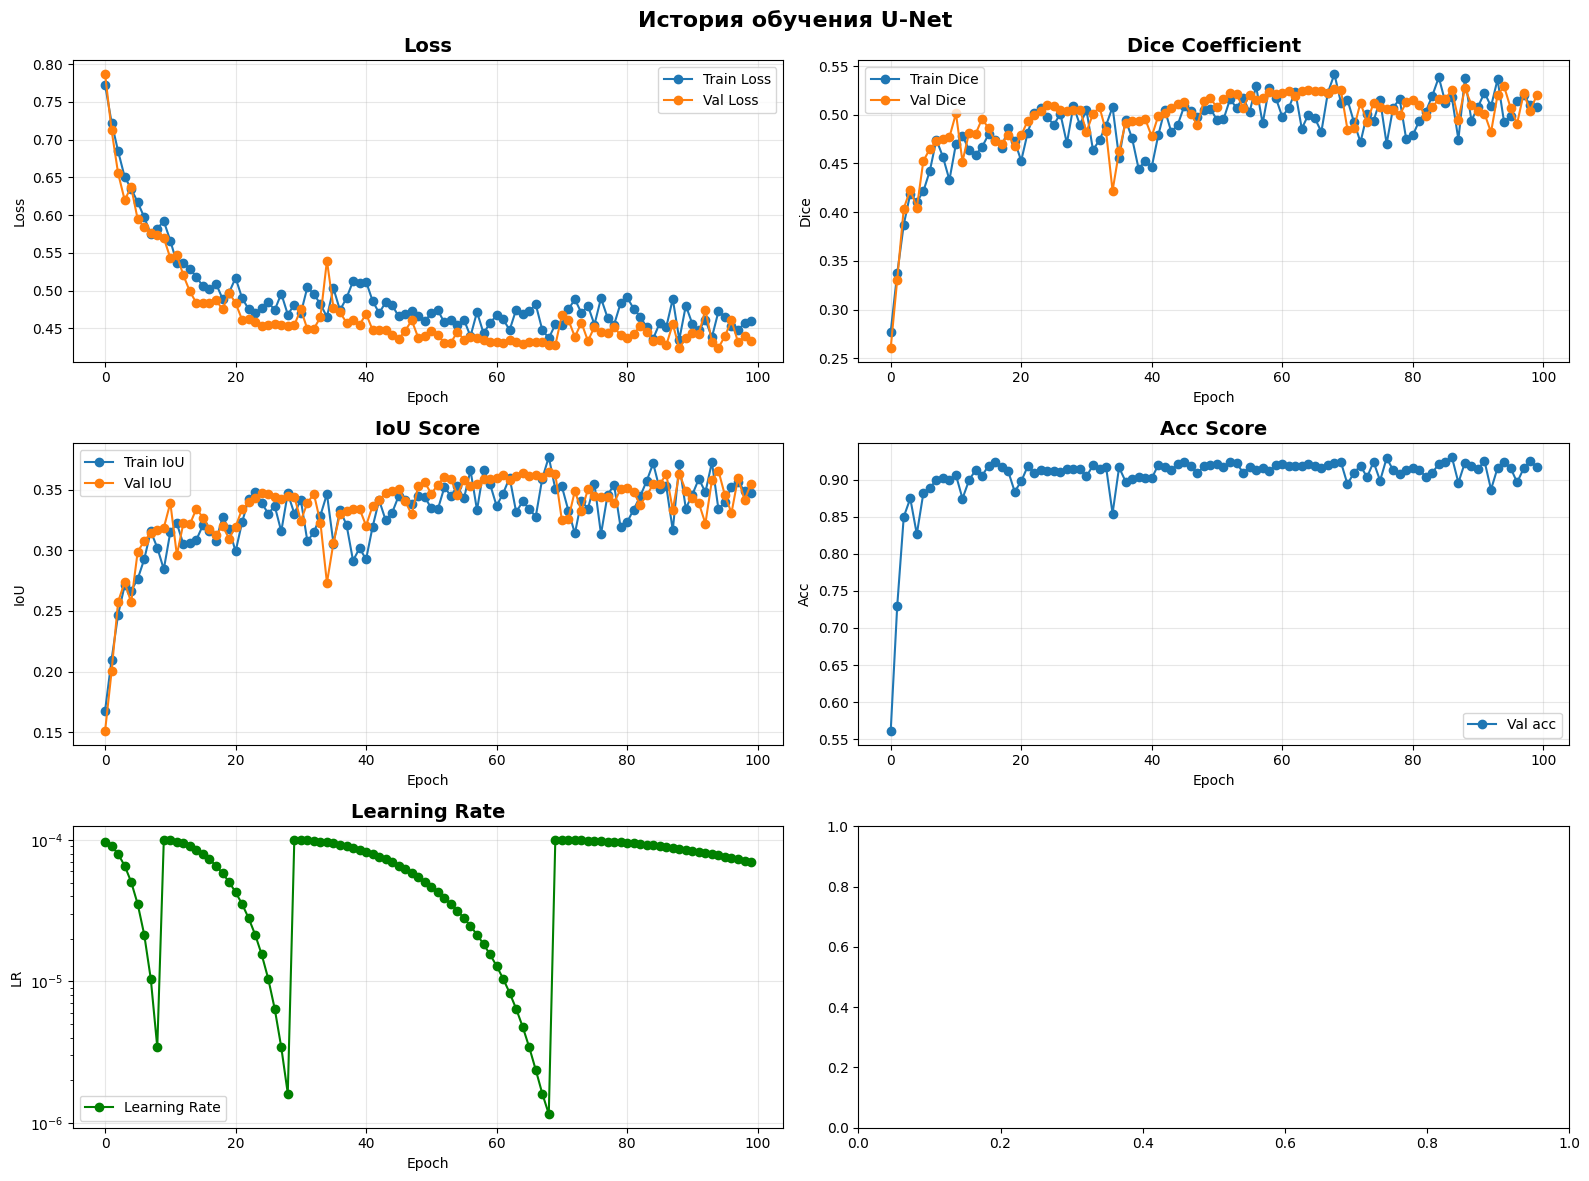

Train Loss: 0.4596
Val Loss: 0.4329
Train Dice: 0.5081
Val Dice: 0.5198
Train IoU: 0.3472
Val IoU: 0.3552
Val Accuracy: 0.9167


In [40]:
plot_training_history(my_history_freeze_all)

Эпоха: 95
Val Dice: 0.5292
Val IoU: 0.3657
Val Accuracy: 0.9232


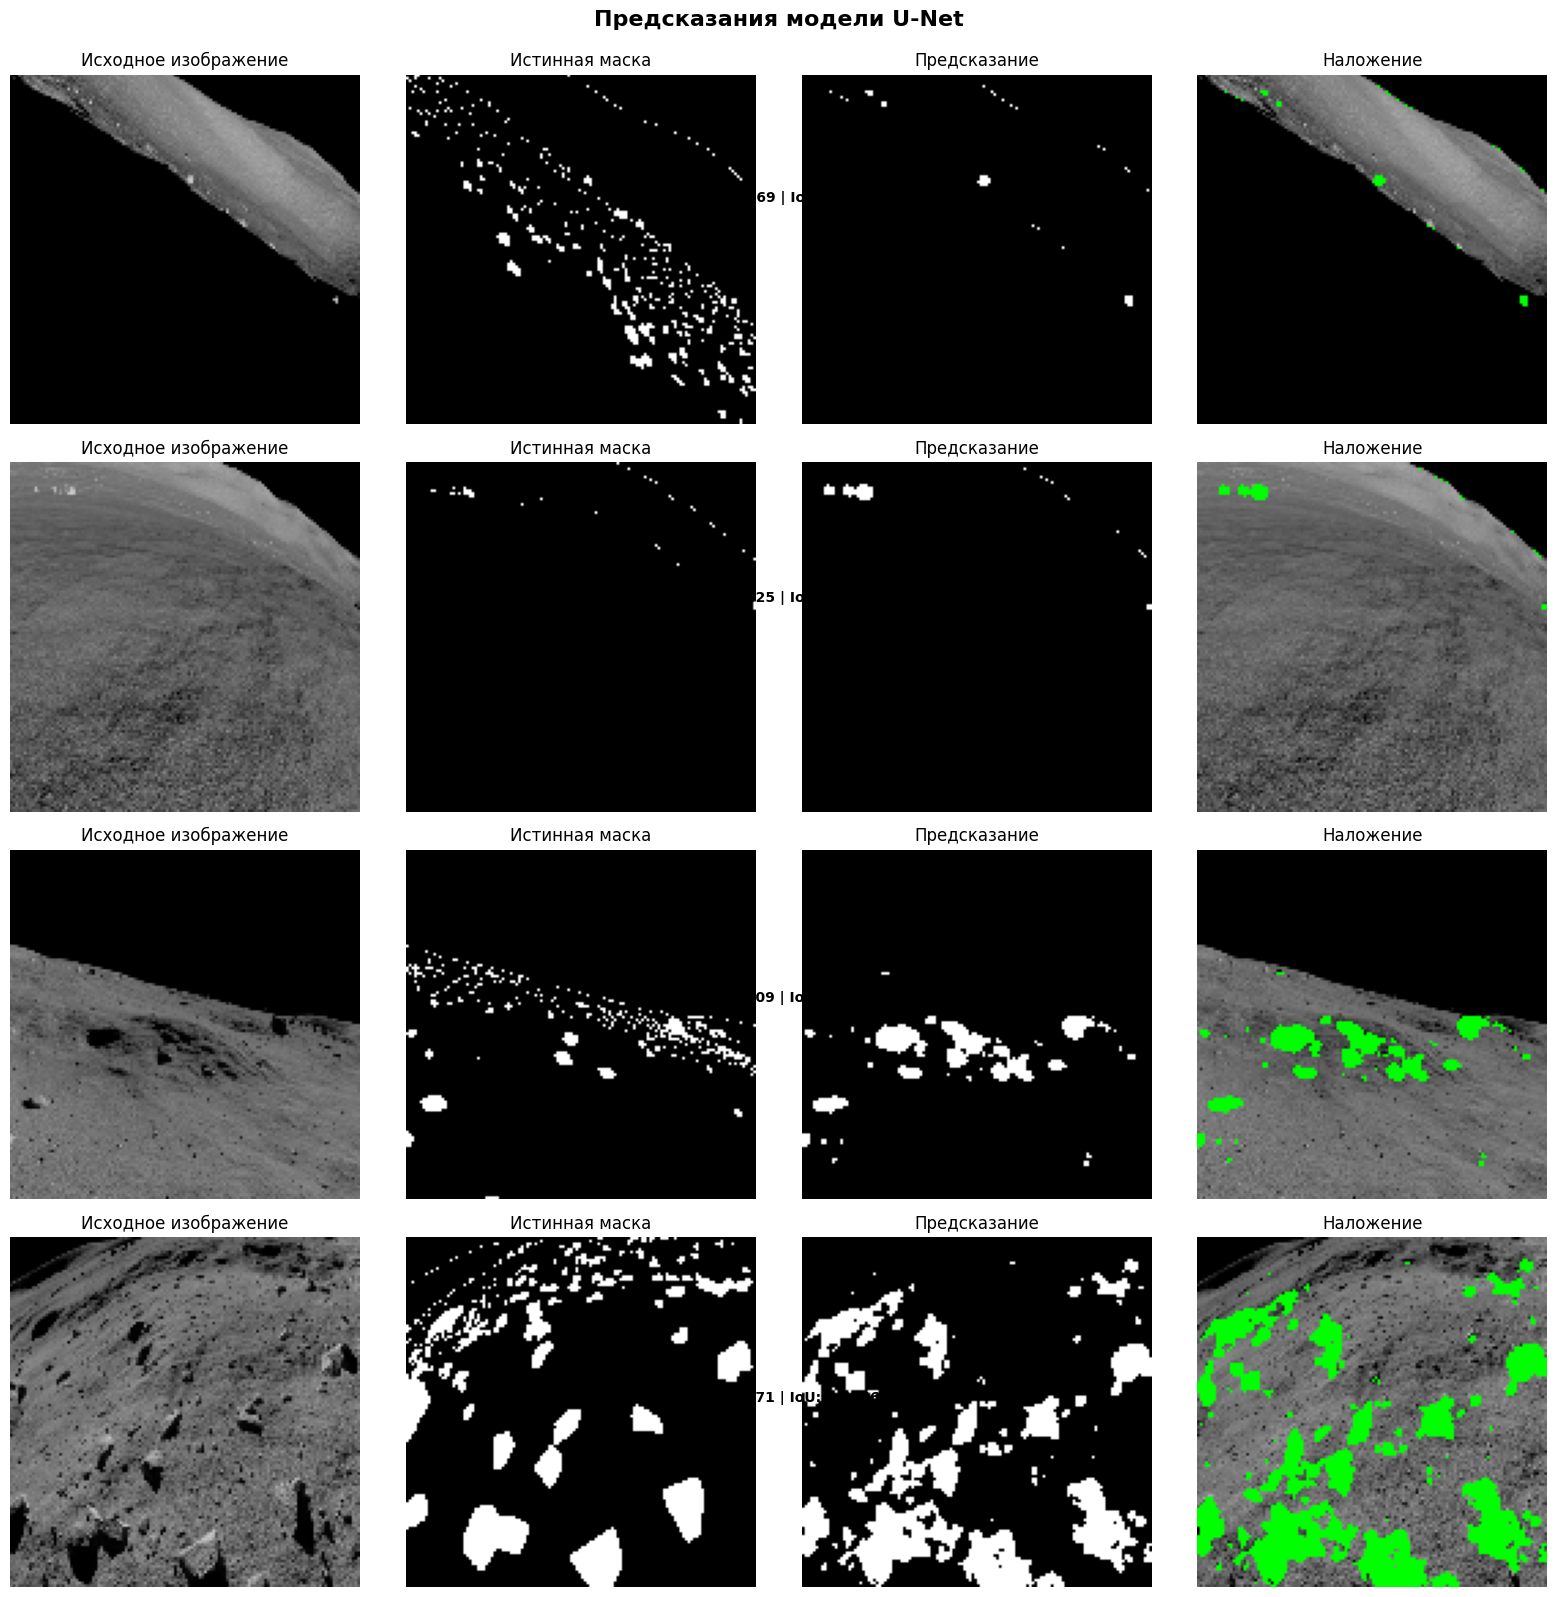

In [41]:
best_model = MyNNUNetFreeze(out_channels=1, freeze_all=True)

checkpoint_unet_freeze = torch.load(SAVE_PATH_FREEZE_ALL, map_location=device)
best_model.load_state_dict(checkpoint_unet_freeze['model_state_dict'])
best_model = best_model.to(device)

print(f"Эпоха: {checkpoint_unet_freeze['epoch'] + 1}")
print(f"Val Dice: {checkpoint_unet_freeze['val_dice']:.4f}")
print(f"Val IoU: {checkpoint_unet_freeze['val_iou']:.4f}")
print(f"Val Accuracy: {checkpoint_unet_freeze['val_acc']:.4f}")

visualize_predictions(best_model, val_loader, device, num_samples=4)

## Обучение варианта B (частичная заморозка)

In [42]:
my_model_freeze_part = MyNNUNetFreeze(out_channels=1, freeze_all=False)

my_model_criterion = CombinedLoss(bce_weight=0.3, dice_weight=0.7)

encoder_params = []
decoder_params = []

for name, param in my_model_freeze_part.named_parameters():
    if 'encoder' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

my_optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': 1e-4},  # Меньший LR для предобученных слоев
    {'params': decoder_params, 'lr': 1e-3}   # Обычный LR для новых слоев
])

my_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    my_optimizer,
    T_0=10,        # ← каждые 10 эпох — рестарт
    T_mult=2,      # ← следующий цикл в 2× длиннее
    eta_min=1e-6   # ← минимальный LR
)

NUM_EPOCHS = 100
SAVE_PATH_FREEZE_PART = 'best_my_unet_freeze_part.pth'

print(f"   Эпох: {NUM_EPOCHS}")
print(f"   Encoder LR: 1e-4 (fine-tuning)")
print(f"   Decoder LR: 1e-3")
print(f"   Модель будет сохранена в: {SAVE_PATH_FREEZE_PART}")

my_history_freeze_part = train_model(
    model=my_model_freeze_part,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=my_model_criterion,
    optimizer=my_optimizer,
    scheduler=my_scheduler,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_path=SAVE_PATH_FREEZE_PART
)

   Эпох: 100
   Encoder LR: 1e-4 (fine-tuning)
   Decoder LR: 1e-3
   Модель будет сохранена в: best_my_unet_freeze_part.pth
Эпоха 1/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.02it/s, loss=0.6861, dice=0.4449, iou=0.2861, acc=0.7859]



 Результаты эпохи 1:
  Train - Loss: 0.6927, Dice: 0.3701, IoU: 0.2334
  Val   - Loss: 0.7252, Dice: 0.3696, IoU: 0.2292, Acc: 0.7915
  LR: 0.000098
  Сохранена лучшая модель! Dice: 0.3696
Эпоха 2/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.91it/s, loss=0.5892, dice=0.5004, iou=0.3337, acc=0.8393]



 Результаты эпохи 2:
  Train - Loss: 0.6553, Dice: 0.3886, IoU: 0.2464
  Val   - Loss: 0.6497, Dice: 0.3961, IoU: 0.2499, Acc: 0.8159
  LR: 0.000091
  Сохранена лучшая модель! Dice: 0.3961
Эпоха 3/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.26it/s, loss=0.5409, dice=0.5184, iou=0.3499, acc=0.8661]



 Результаты эпохи 3:
  Train - Loss: 0.6170, Dice: 0.4250, IoU: 0.2735
  Val   - Loss: 0.5967, Dice: 0.4238, IoU: 0.2734, Acc: 0.8592
  LR: 0.000080
  Сохранена лучшая модель! Dice: 0.4238
Эпоха 4/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.61it/s, loss=0.5091, dice=0.5581, iou=0.3871, acc=0.8995]



 Результаты эпохи 4:
  Train - Loss: 0.5795, Dice: 0.4658, IoU: 0.3080
  Val   - Loss: 0.5552, Dice: 0.4724, IoU: 0.3139, Acc: 0.8993
  LR: 0.000066
  Сохранена лучшая модель! Dice: 0.4724
Эпоха 5/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.11it/s, loss=0.4918, dice=0.5418, iou=0.3715, acc=0.8774]



 Результаты эпохи 5:
  Train - Loss: 0.5815, Dice: 0.4319, IoU: 0.2830
  Val   - Loss: 0.5546, Dice: 0.4431, IoU: 0.2891, Acc: 0.8696
  LR: 0.000051
Эпоха 6/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 22.42it/s, loss=0.4771, dice=0.5642, iou=0.3929, acc=0.8913]



 Результаты эпохи 6:
  Train - Loss: 0.5441, Dice: 0.4875, IoU: 0.3280
  Val   - Loss: 0.5396, Dice: 0.4636, IoU: 0.3069, Acc: 0.8809
  LR: 0.000035
Эпоха 7/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.57it/s, loss=0.4779, dice=0.5629, iou=0.3917, acc=0.9025]



 Результаты эпохи 7:
  Train - Loss: 0.5436, Dice: 0.4724, IoU: 0.3124
  Val   - Loss: 0.5329, Dice: 0.4784, IoU: 0.3189, Acc: 0.8956
  LR: 0.000021
  Сохранена лучшая модель! Dice: 0.4784
Эпоха 8/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 29.88it/s, loss=0.4762, dice=0.5626, iou=0.3914, acc=0.8986]



 Результаты эпохи 8:
  Train - Loss: 0.5206, Dice: 0.5025, IoU: 0.3387
  Val   - Loss: 0.5305, Dice: 0.4769, IoU: 0.3174, Acc: 0.8903
  LR: 0.000010
Эпоха 9/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.95it/s, loss=0.4720, dice=0.5619, iou=0.3907, acc=0.8950]



 Результаты эпохи 9:
  Train - Loss: 0.5333, Dice: 0.4752, IoU: 0.3172
  Val   - Loss: 0.5270, Dice: 0.4790, IoU: 0.3188, Acc: 0.8893
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.4790
Эпоха 10/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.18it/s, loss=0.4669, dice=0.5702, iou=0.3988, acc=0.8992]



 Результаты эпохи 10:
  Train - Loss: 0.5288, Dice: 0.4792, IoU: 0.3201
  Val   - Loss: 0.5243, Dice: 0.4801, IoU: 0.3207, Acc: 0.8939
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4801
Эпоха 11/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.61it/s, loss=0.4543, dice=0.5627, iou=0.3915, acc=0.8940]



 Результаты эпохи 11:
  Train - Loss: 0.5387, Dice: 0.4614, IoU: 0.3056
  Val   - Loss: 0.5076, Dice: 0.4785, IoU: 0.3199, Acc: 0.8932
  LR: 0.000099
Эпоха 12/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.00it/s, loss=0.4440, dice=0.5683, iou=0.3969, acc=0.8984]



 Результаты эпохи 12:
  Train - Loss: 0.5311, Dice: 0.4572, IoU: 0.3022
  Val   - Loss: 0.4982, Dice: 0.4870, IoU: 0.3285, Acc: 0.9048
  LR: 0.000098
  Сохранена лучшая модель! Dice: 0.4870
Эпоха 13/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.00it/s, loss=0.4725, dice=0.5112, iou=0.3433, acc=0.8780]



 Результаты эпохи 13:
  Train - Loss: 0.5198, Dice: 0.4614, IoU: 0.3067
  Val   - Loss: 0.4949, Dice: 0.4754, IoU: 0.3178, Acc: 0.9019
  LR: 0.000095
Эпоха 14/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.06it/s, loss=0.4793, dice=0.5263, iou=0.3571, acc=0.8733]



 Результаты эпохи 14:
  Train - Loss: 0.5150, Dice: 0.4646, IoU: 0.3088
  Val   - Loss: 0.5340, Dice: 0.4451, IoU: 0.2886, Acc: 0.8704
  LR: 0.000091
Эпоха 15/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.75it/s, loss=0.4450, dice=0.5506, iou=0.3799, acc=0.8976]



 Результаты эпохи 15:
  Train - Loss: 0.5124, Dice: 0.4604, IoU: 0.3065
  Val   - Loss: 0.4853, Dice: 0.4805, IoU: 0.3210, Acc: 0.9032
  LR: 0.000086
Эпоха 16/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.24it/s, loss=0.4186, dice=0.5780, iou=0.4065, acc=0.9157]



 Результаты эпохи 16:
  Train - Loss: 0.5222, Dice: 0.4438, IoU: 0.2907
  Val   - Loss: 0.4750, Dice: 0.4883, IoU: 0.3290, Acc: 0.9123
  LR: 0.000080
  Сохранена лучшая модель! Dice: 0.4883
Эпоха 17/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.23it/s, loss=0.4268, dice=0.5632, iou=0.3920, acc=0.8887]



 Результаты эпохи 17:
  Train - Loss: 0.4719, Dice: 0.5087, IoU: 0.3457
  Val   - Loss: 0.5007, Dice: 0.4638, IoU: 0.3058, Acc: 0.8803
  LR: 0.000073
Эпоха 18/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.60it/s, loss=0.4117, dice=0.5684, iou=0.3970, acc=0.9172]



 Результаты эпохи 18:
  Train - Loss: 0.5041, Dice: 0.4689, IoU: 0.3122
  Val   - Loss: 0.4621, Dice: 0.4940, IoU: 0.3338, Acc: 0.9207
  LR: 0.000066
  Сохранена лучшая модель! Dice: 0.4940
Эпоха 19/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.11it/s, loss=0.3915, dice=0.6032, iou=0.4318, acc=0.9168]



 Результаты эпохи 19:
  Train - Loss: 0.4862, Dice: 0.4905, IoU: 0.3317
  Val   - Loss: 0.4399, Dice: 0.5251, IoU: 0.3624, Acc: 0.9226
  LR: 0.000058
  Сохранена лучшая модель! Dice: 0.5251
Эпоха 20/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.46it/s, loss=0.4053, dice=0.5770, iou=0.4055, acc=0.9226]



 Результаты эпохи 20:
  Train - Loss: 0.4815, Dice: 0.4944, IoU: 0.3349
  Val   - Loss: 0.4432, Dice: 0.5176, IoU: 0.3555, Acc: 0.9299
  LR: 0.000051
Эпоха 21/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.30it/s, loss=0.4140, dice=0.5677, iou=0.3963, acc=0.8999]



 Результаты эпохи 21:
  Train - Loss: 0.4771, Dice: 0.4996, IoU: 0.3423
  Val   - Loss: 0.4664, Dice: 0.4922, IoU: 0.3324, Acc: 0.9046
  LR: 0.000043
Эпоха 22/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.27it/s, loss=0.4128, dice=0.5676, iou=0.3962, acc=0.9132]



 Результаты эпохи 22:
  Train - Loss: 0.4998, Dice: 0.4602, IoU: 0.3039
  Val   - Loss: 0.4614, Dice: 0.4890, IoU: 0.3309, Acc: 0.9190
  LR: 0.000035
Эпоха 23/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.02it/s, loss=0.4095, dice=0.5623, iou=0.3911, acc=0.9199]



 Результаты эпохи 23:
  Train - Loss: 0.4790, Dice: 0.4891, IoU: 0.3293
  Val   - Loss: 0.4506, Dice: 0.5005, IoU: 0.3398, Acc: 0.9261
  LR: 0.000028
Эпоха 24/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.65it/s, loss=0.3983, dice=0.5842, iou=0.4126, acc=0.9103]



 Результаты эпохи 24:
  Train - Loss: 0.4684, Dice: 0.5105, IoU: 0.3488
  Val   - Loss: 0.4426, Dice: 0.5158, IoU: 0.3526, Acc: 0.9171
  LR: 0.000021
Эпоха 25/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.04it/s, loss=0.3953, dice=0.5884, iou=0.4169, acc=0.9118]



 Результаты эпохи 25:
  Train - Loss: 0.4694, Dice: 0.5046, IoU: 0.3428
  Val   - Loss: 0.4497, Dice: 0.5095, IoU: 0.3478, Acc: 0.9162
  LR: 0.000015
Эпоха 26/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.59it/s, loss=0.4020, dice=0.5794, iou=0.4079, acc=0.9184]



 Результаты эпохи 26:
  Train - Loss: 0.4715, Dice: 0.5007, IoU: 0.3388
  Val   - Loss: 0.4479, Dice: 0.5089, IoU: 0.3470, Acc: 0.9231
  LR: 0.000010
Эпоха 27/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.30it/s, loss=0.3971, dice=0.5842, iou=0.4127, acc=0.9126]



 Результаты эпохи 27:
  Train - Loss: 0.4802, Dice: 0.4878, IoU: 0.3290
  Val   - Loss: 0.4499, Dice: 0.5081, IoU: 0.3467, Acc: 0.9160
  LR: 0.000006
Эпоха 28/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.01it/s, loss=0.3989, dice=0.5796, iou=0.4080, acc=0.9121]



 Результаты эпохи 28:
  Train - Loss: 0.4773, Dice: 0.4932, IoU: 0.3339
  Val   - Loss: 0.4502, Dice: 0.5056, IoU: 0.3442, Acc: 0.9161
  LR: 0.000003
Эпоха 29/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s, loss=0.4001, dice=0.5781, iou=0.4066, acc=0.9128]



 Результаты эпохи 29:
  Train - Loss: 0.4599, Dice: 0.5158, IoU: 0.3513
  Val   - Loss: 0.4482, Dice: 0.5071, IoU: 0.3455, Acc: 0.9185
  LR: 0.000002
Эпоха 30/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.31it/s, loss=0.4003, dice=0.5778, iou=0.4063, acc=0.9113]



 Результаты эпохи 30:
  Train - Loss: 0.4709, Dice: 0.5005, IoU: 0.3401
  Val   - Loss: 0.4481, Dice: 0.5095, IoU: 0.3478, Acc: 0.9167
  LR: 0.000100
Эпоха 31/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.47it/s, loss=0.4204, dice=0.5547, iou=0.3838, acc=0.8968]



 Результаты эпохи 31:
  Train - Loss: 0.4637, Dice: 0.5100, IoU: 0.3484
  Val   - Loss: 0.4675, Dice: 0.4801, IoU: 0.3225, Acc: 0.9051
  LR: 0.000100
Эпоха 32/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.59it/s, loss=0.3848, dice=0.5953, iou=0.4238, acc=0.9202]



 Результаты эпохи 32:
  Train - Loss: 0.4803, Dice: 0.4905, IoU: 0.3302
  Val   - Loss: 0.4476, Dice: 0.5064, IoU: 0.3453, Acc: 0.9156
  LR: 0.000099
Эпоха 33/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.31it/s, loss=0.4123, dice=0.5632, iou=0.3920, acc=0.9145]



 Результаты эпохи 33:
  Train - Loss: 0.4951, Dice: 0.4766, IoU: 0.3193
  Val   - Loss: 0.4493, Dice: 0.5016, IoU: 0.3418, Acc: 0.9222
  LR: 0.000099
Эпоха 34/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.38it/s, loss=0.4212, dice=0.5518, iou=0.3810, acc=0.9087]



 Результаты эпохи 34:
  Train - Loss: 0.5017, Dice: 0.4596, IoU: 0.3036
  Val   - Loss: 0.4657, Dice: 0.4805, IoU: 0.3229, Acc: 0.9154
  LR: 0.000098
Эпоха 35/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.51it/s, loss=0.4064, dice=0.5650, iou=0.3937, acc=0.9173]



 Результаты эпохи 35:
  Train - Loss: 0.4951, Dice: 0.4682, IoU: 0.3107
  Val   - Loss: 0.4602, Dice: 0.4837, IoU: 0.3244, Acc: 0.9213
  LR: 0.000096
Эпоха 36/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.17it/s, loss=0.4018, dice=0.5715, iou=0.4001, acc=0.9077]



 Результаты эпохи 36:
  Train - Loss: 0.4780, Dice: 0.4879, IoU: 0.3278
  Val   - Loss: 0.4494, Dice: 0.5015, IoU: 0.3431, Acc: 0.9161
  LR: 0.000095
Эпоха 37/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.53it/s, loss=0.3969, dice=0.5746, iou=0.4031, acc=0.9057]



 Результаты эпохи 37:
  Train - Loss: 0.4746, Dice: 0.4917, IoU: 0.3365
  Val   - Loss: 0.4520, Dice: 0.4896, IoU: 0.3307, Acc: 0.9131
  LR: 0.000093
Эпоха 38/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.60it/s, loss=0.4134, dice=0.5600, iou=0.3889, acc=0.9162]



 Результаты эпохи 38:
  Train - Loss: 0.5084, Dice: 0.4503, IoU: 0.2983
  Val   - Loss: 0.4650, Dice: 0.4797, IoU: 0.3213, Acc: 0.9173
  LR: 0.000091
Эпоха 39/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.55it/s, loss=0.4014, dice=0.5693, iou=0.3980, acc=0.9098]



 Результаты эпохи 39:
  Train - Loss: 0.4812, Dice: 0.4873, IoU: 0.3286
  Val   - Loss: 0.4485, Dice: 0.4957, IoU: 0.3379, Acc: 0.9188
  LR: 0.000088
Эпоха 40/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.68it/s, loss=0.4010, dice=0.5751, iou=0.4036, acc=0.8977]



 Результаты эпохи 40:
  Train - Loss: 0.4829, Dice: 0.4846, IoU: 0.3274
  Val   - Loss: 0.4511, Dice: 0.5032, IoU: 0.3430, Acc: 0.9052
  LR: 0.000086
Эпоха 41/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.64it/s, loss=0.3985, dice=0.5708, iou=0.3994, acc=0.9097]



 Результаты эпохи 41:
  Train - Loss: 0.4646, Dice: 0.5071, IoU: 0.3461
  Val   - Loss: 0.4459, Dice: 0.5012, IoU: 0.3401, Acc: 0.9184
  LR: 0.000083
Эпоха 42/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.34it/s, loss=0.4059, dice=0.5683, iou=0.3969, acc=0.9081]



 Результаты эпохи 42:
  Train - Loss: 0.4691, Dice: 0.4999, IoU: 0.3423
  Val   - Loss: 0.4387, Dice: 0.5123, IoU: 0.3508, Acc: 0.9195
  LR: 0.000080
Эпоха 43/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s, loss=0.3949, dice=0.5803, iou=0.4088, acc=0.9119]



 Результаты эпохи 43:
  Train - Loss: 0.4715, Dice: 0.4979, IoU: 0.3386
  Val   - Loss: 0.4477, Dice: 0.5005, IoU: 0.3398, Acc: 0.9153
  LR: 0.000076
Эпоха 44/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.57it/s, loss=0.4139, dice=0.5529, iou=0.3821, acc=0.9068]



 Результаты эпохи 44:
  Train - Loss: 0.4686, Dice: 0.5051, IoU: 0.3450
  Val   - Loss: 0.4542, Dice: 0.4895, IoU: 0.3310, Acc: 0.9153
  LR: 0.000073
Эпоха 45/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.62it/s, loss=0.4065, dice=0.5620, iou=0.3908, acc=0.9057]



 Результаты эпохи 45:
  Train - Loss: 0.4600, Dice: 0.5116, IoU: 0.3487
  Val   - Loss: 0.4550, Dice: 0.4911, IoU: 0.3327, Acc: 0.9090
  LR: 0.000069
Эпоха 46/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.19it/s, loss=0.4103, dice=0.5517, iou=0.3810, acc=0.9151]



 Результаты эпохи 46:
  Train - Loss: 0.4596, Dice: 0.5103, IoU: 0.3501
  Val   - Loss: 0.4418, Dice: 0.5041, IoU: 0.3441, Acc: 0.9220
  LR: 0.000066
Эпоха 47/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s, loss=0.3950, dice=0.5823, iou=0.4107, acc=0.9162]



 Результаты эпохи 47:
  Train - Loss: 0.4752, Dice: 0.4964, IoU: 0.3378
  Val   - Loss: 0.4329, Dice: 0.5197, IoU: 0.3596, Acc: 0.9255
  LR: 0.000062
Эпоха 48/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.25it/s, loss=0.3917, dice=0.5840, iou=0.4124, acc=0.9164]



 Результаты эпохи 48:
  Train - Loss: 0.4799, Dice: 0.4883, IoU: 0.3337
  Val   - Loss: 0.4319, Dice: 0.5198, IoU: 0.3572, Acc: 0.9250
  LR: 0.000058
Эпоха 49/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.82it/s, loss=0.3912, dice=0.5825, iou=0.4109, acc=0.9079]



 Результаты эпохи 49:
  Train - Loss: 0.4570, Dice: 0.5170, IoU: 0.3552
  Val   - Loss: 0.4386, Dice: 0.5119, IoU: 0.3526, Acc: 0.9173
  LR: 0.000054
Эпоха 50/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.49it/s, loss=0.4064, dice=0.5623, iou=0.3911, acc=0.9193]



 Результаты эпохи 50:
  Train - Loss: 0.4714, Dice: 0.4905, IoU: 0.3330
  Val   - Loss: 0.4449, Dice: 0.5002, IoU: 0.3394, Acc: 0.9250
  LR: 0.000051
Эпоха 51/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.68it/s, loss=0.3901, dice=0.5823, iou=0.4108, acc=0.9154]



 Результаты эпохи 51:
  Train - Loss: 0.4711, Dice: 0.4943, IoU: 0.3365
  Val   - Loss: 0.4293, Dice: 0.5192, IoU: 0.3569, Acc: 0.9246
  LR: 0.000047
Эпоха 52/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.11it/s, loss=0.3805, dice=0.5976, iou=0.4261, acc=0.9170]



 Результаты эпохи 52:
  Train - Loss: 0.4598, Dice: 0.5171, IoU: 0.3541
  Val   - Loss: 0.4258, Dice: 0.5249, IoU: 0.3644, Acc: 0.9257
  LR: 0.000043
Эпоха 53/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.04it/s, loss=0.3830, dice=0.5933, iou=0.4218, acc=0.9132]



 Результаты эпохи 53:
  Train - Loss: 0.4365, Dice: 0.5357, IoU: 0.3731
  Val   - Loss: 0.4314, Dice: 0.5200, IoU: 0.3593, Acc: 0.9209
  LR: 0.000039
Эпоха 54/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.61it/s, loss=0.3934, dice=0.5751, iou=0.4036, acc=0.9096]



 Результаты эпохи 54:
  Train - Loss: 0.4464, Dice: 0.5247, IoU: 0.3626
  Val   - Loss: 0.4336, Dice: 0.5143, IoU: 0.3532, Acc: 0.9216
  LR: 0.000035
Эпоха 55/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.61it/s, loss=0.3841, dice=0.5887, iou=0.4171, acc=0.9136]



 Результаты эпохи 55:
  Train - Loss: 0.4578, Dice: 0.5105, IoU: 0.3484
  Val   - Loss: 0.4359, Dice: 0.5130, IoU: 0.3523, Acc: 0.9192
  LR: 0.000032
Эпоха 56/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.57it/s, loss=0.3895, dice=0.5825, iou=0.4110, acc=0.9104]



 Результаты эпохи 56:
  Train - Loss: 0.4275, Dice: 0.5478, IoU: 0.3833
  Val   - Loss: 0.4377, Dice: 0.5130, IoU: 0.3533, Acc: 0.9195
  LR: 0.000028
Эпоха 57/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.65it/s, loss=0.3828, dice=0.5935, iou=0.4220, acc=0.9123]



 Результаты эпохи 57:
  Train - Loss: 0.4546, Dice: 0.5134, IoU: 0.3541
  Val   - Loss: 0.4305, Dice: 0.5204, IoU: 0.3591, Acc: 0.9187
  LR: 0.000025
Эпоха 58/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.01it/s, loss=0.3805, dice=0.5914, iou=0.4198, acc=0.9172]



 Результаты эпохи 58:
  Train - Loss: 0.4531, Dice: 0.5168, IoU: 0.3559
  Val   - Loss: 0.4249, Dice: 0.5265, IoU: 0.3648, Acc: 0.9254
  LR: 0.000021
  Сохранена лучшая модель! Dice: 0.5265
Эпоха 59/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.91it/s, loss=0.3844, dice=0.5912, iou=0.4196, acc=0.9100]



 Результаты эпохи 59:
  Train - Loss: 0.4650, Dice: 0.5071, IoU: 0.3496
  Val   - Loss: 0.4396, Dice: 0.5123, IoU: 0.3522, Acc: 0.9134
  LR: 0.000018
Эпоха 60/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.86it/s, loss=0.3832, dice=0.5947, iou=0.4232, acc=0.9146]



 Результаты эпохи 60:
  Train - Loss: 0.4163, Dice: 0.5601, IoU: 0.3950
  Val   - Loss: 0.4308, Dice: 0.5207, IoU: 0.3592, Acc: 0.9204
  LR: 0.000015
Эпоха 61/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.33it/s, loss=0.3912, dice=0.5803, iou=0.4088, acc=0.9098]



 Результаты эпохи 61:
  Train - Loss: 0.4711, Dice: 0.4956, IoU: 0.3366
  Val   - Loss: 0.4346, Dice: 0.5124, IoU: 0.3518, Acc: 0.9198
  LR: 0.000013
Эпоха 62/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.48it/s, loss=0.3824, dice=0.5932, iou=0.4216, acc=0.9152]



 Результаты эпохи 62:
  Train - Loss: 0.4423, Dice: 0.5303, IoU: 0.3669
  Val   - Loss: 0.4299, Dice: 0.5199, IoU: 0.3588, Acc: 0.9220
  LR: 0.000010
Эпоха 63/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.06it/s, loss=0.3911, dice=0.5832, iou=0.4116, acc=0.9159]



 Результаты эпохи 63:
  Train - Loss: 0.4821, Dice: 0.4847, IoU: 0.3287
  Val   - Loss: 0.4272, Dice: 0.5238, IoU: 0.3625, Acc: 0.9251
  LR: 0.000008
Эпоха 64/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.53it/s, loss=0.3849, dice=0.5898, iou=0.4182, acc=0.9180]



 Результаты эпохи 64:
  Train - Loss: 0.4343, Dice: 0.5376, IoU: 0.3763
  Val   - Loss: 0.4256, Dice: 0.5245, IoU: 0.3629, Acc: 0.9261
  LR: 0.000006
Эпоха 65/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.50it/s, loss=0.3804, dice=0.5958, iou=0.4243, acc=0.9197]



 Результаты эпохи 65:
  Train - Loss: 0.4330, Dice: 0.5374, IoU: 0.3757
  Val   - Loss: 0.4222, Dice: 0.5287, IoU: 0.3668, Acc: 0.9277
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.5287
Эпоха 66/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.23it/s, loss=0.3809, dice=0.5930, iou=0.4214, acc=0.9166]



 Результаты эпохи 66:
  Train - Loss: 0.4532, Dice: 0.5188, IoU: 0.3576
  Val   - Loss: 0.4256, Dice: 0.5256, IoU: 0.3646, Acc: 0.9237
  LR: 0.000003
Эпоха 67/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.36it/s, loss=0.3845, dice=0.5862, iou=0.4146, acc=0.9159]



 Результаты эпохи 67:
  Train - Loss: 0.4401, Dice: 0.5322, IoU: 0.3660
  Val   - Loss: 0.4224, Dice: 0.5278, IoU: 0.3658, Acc: 0.9258
  LR: 0.000002
Эпоха 68/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.87it/s, loss=0.3877, dice=0.5876, iou=0.4160, acc=0.9114]



 Результаты эпохи 68:
  Train - Loss: 0.4411, Dice: 0.5319, IoU: 0.3714
  Val   - Loss: 0.4292, Dice: 0.5219, IoU: 0.3612, Acc: 0.9209
  LR: 0.000002
Эпоха 69/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.09it/s, loss=0.3839, dice=0.5917, iou=0.4201, acc=0.9124]



 Результаты эпохи 69:
  Train - Loss: 0.4502, Dice: 0.5173, IoU: 0.3570
  Val   - Loss: 0.4301, Dice: 0.5222, IoU: 0.3608, Acc: 0.9202
  LR: 0.000001
Эпоха 70/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.00it/s, loss=0.3778, dice=0.5985, iou=0.4270, acc=0.9170]



 Результаты эпохи 70:
  Train - Loss: 0.4227, Dice: 0.5543, IoU: 0.3889
  Val   - Loss: 0.4232, Dice: 0.5293, IoU: 0.3676, Acc: 0.9245
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5293
Эпоха 71/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.50it/s, loss=0.4028, dice=0.5657, iou=0.3944, acc=0.9061]



 Результаты эпохи 71:
  Train - Loss: 0.4699, Dice: 0.5020, IoU: 0.3445
  Val   - Loss: 0.4430, Dice: 0.5020, IoU: 0.3427, Acc: 0.9180
  LR: 0.000100
Эпоха 72/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.16it/s, loss=0.3950, dice=0.5735, iou=0.4020, acc=0.9011]



 Результаты эпохи 72:
  Train - Loss: 0.4522, Dice: 0.5165, IoU: 0.3562
  Val   - Loss: 0.4406, Dice: 0.5065, IoU: 0.3464, Acc: 0.9150
  LR: 0.000100
Эпоха 73/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.21it/s, loss=0.3887, dice=0.5797, iou=0.4082, acc=0.9122]



 Результаты эпохи 73:
  Train - Loss: 0.4514, Dice: 0.5205, IoU: 0.3576
  Val   - Loss: 0.4396, Dice: 0.5066, IoU: 0.3457, Acc: 0.9175
  LR: 0.000100
Эпоха 74/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.09it/s, loss=0.3945, dice=0.5813, iou=0.4098, acc=0.9009]



 Результаты эпохи 74:
  Train - Loss: 0.4648, Dice: 0.5081, IoU: 0.3467
  Val   - Loss: 0.4766, Dice: 0.4740, IoU: 0.3165, Acc: 0.8915
  LR: 0.000099
Эпоха 75/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.25it/s, loss=0.3837, dice=0.5932, iou=0.4216, acc=0.9147]



 Результаты эпохи 75:
  Train - Loss: 0.4651, Dice: 0.5012, IoU: 0.3418
  Val   - Loss: 0.4441, Dice: 0.5000, IoU: 0.3434, Acc: 0.9187
  LR: 0.000099
Эпоха 76/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.66it/s, loss=0.3928, dice=0.5770, iou=0.4055, acc=0.9071]



 Результаты эпохи 76:
  Train - Loss: 0.4542, Dice: 0.5119, IoU: 0.3497
  Val   - Loss: 0.4471, Dice: 0.5016, IoU: 0.3418, Acc: 0.9088
  LR: 0.000099
Эпоха 77/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.77it/s, loss=0.3942, dice=0.5772, iou=0.4057, acc=0.9153]



 Результаты эпохи 77:
  Train - Loss: 0.4592, Dice: 0.5129, IoU: 0.3524
  Val   - Loss: 0.4405, Dice: 0.5095, IoU: 0.3497, Acc: 0.9166
  LR: 0.000098
Эпоха 78/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.75it/s, loss=0.3806, dice=0.5938, iou=0.4223, acc=0.9214]



 Результаты эпохи 78:
  Train - Loss: 0.4611, Dice: 0.5108, IoU: 0.3478
  Val   - Loss: 0.4376, Dice: 0.5106, IoU: 0.3500, Acc: 0.9226
  LR: 0.000098
Эпоха 79/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s, loss=0.3891, dice=0.5875, iou=0.4160, acc=0.9105]



 Результаты эпохи 79:
  Train - Loss: 0.4298, Dice: 0.5443, IoU: 0.3809
  Val   - Loss: 0.4374, Dice: 0.5122, IoU: 0.3545, Acc: 0.9185
  LR: 0.000097
Эпоха 80/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.28it/s, loss=0.4257, dice=0.5320, iou=0.3624, acc=0.9207]



 Результаты эпохи 80:
  Train - Loss: 0.4488, Dice: 0.5184, IoU: 0.3537
  Val   - Loss: 0.4515, Dice: 0.4868, IoU: 0.3281, Acc: 0.9289
  LR: 0.000096
Эпоха 81/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.59it/s, loss=0.4005, dice=0.5732, iou=0.4018, acc=0.9026]



 Результаты эпохи 81:
  Train - Loss: 0.4432, Dice: 0.5294, IoU: 0.3662
  Val   - Loss: 0.4424, Dice: 0.5076, IoU: 0.3489, Acc: 0.9116
  LR: 0.000095
Эпоха 82/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.93it/s, loss=0.4274, dice=0.5449, iou=0.3745, acc=0.8976]



 Результаты эпохи 82:
  Train - Loss: 0.4589, Dice: 0.5090, IoU: 0.3477
  Val   - Loss: 0.4488, Dice: 0.5018, IoU: 0.3420, Acc: 0.9139
  LR: 0.000095
Эпоха 83/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.62it/s, loss=0.3951, dice=0.5706, iou=0.3992, acc=0.9140]



 Результаты эпохи 83:
  Train - Loss: 0.4574, Dice: 0.5098, IoU: 0.3495
  Val   - Loss: 0.4301, Dice: 0.5151, IoU: 0.3552, Acc: 0.9257
  LR: 0.000094
Эпоха 84/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.94it/s, loss=0.3845, dice=0.5872, iou=0.4156, acc=0.9152]



 Результаты эпохи 84:
  Train - Loss: 0.4382, Dice: 0.5309, IoU: 0.3690
  Val   - Loss: 0.4372, Dice: 0.5087, IoU: 0.3491, Acc: 0.9227
  LR: 0.000093
Эпоха 85/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.11it/s, loss=0.3942, dice=0.5748, iou=0.4033, acc=0.9131]



 Результаты эпохи 85:
  Train - Loss: 0.4251, Dice: 0.5541, IoU: 0.3895
  Val   - Loss: 0.4382, Dice: 0.5107, IoU: 0.3494, Acc: 0.9212
  LR: 0.000092
Эпоха 86/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.01it/s, loss=0.4177, dice=0.5544, iou=0.3835, acc=0.8971]



 Результаты эпохи 86:
  Train - Loss: 0.4718, Dice: 0.4992, IoU: 0.3399
  Val   - Loss: 0.4501, Dice: 0.4939, IoU: 0.3345, Acc: 0.9115
  LR: 0.000091
Эпоха 87/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.23it/s, loss=0.3966, dice=0.5722, iou=0.4008, acc=0.9043]



 Результаты эпохи 87:
  Train - Loss: 0.4164, Dice: 0.5622, IoU: 0.3950
  Val   - Loss: 0.4393, Dice: 0.5085, IoU: 0.3485, Acc: 0.9137
  LR: 0.000089
Эпоха 88/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.44it/s, loss=0.4212, dice=0.5487, iou=0.3781, acc=0.9011]



 Результаты эпохи 88:
  Train - Loss: 0.4514, Dice: 0.5198, IoU: 0.3616
  Val   - Loss: 0.4528, Dice: 0.4943, IoU: 0.3356, Acc: 0.9128
  LR: 0.000088
Эпоха 89/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.93it/s, loss=0.4089, dice=0.5585, iou=0.3874, acc=0.9100]



 Результаты эпохи 89:
  Train - Loss: 0.4548, Dice: 0.5142, IoU: 0.3530
  Val   - Loss: 0.4434, Dice: 0.5022, IoU: 0.3450, Acc: 0.9199
  LR: 0.000087
Эпоха 90/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.22it/s, loss=0.3916, dice=0.5794, iou=0.4079, acc=0.9131]



 Результаты эпохи 90:
  Train - Loss: 0.4488, Dice: 0.5232, IoU: 0.3620
  Val   - Loss: 0.4352, Dice: 0.5139, IoU: 0.3553, Acc: 0.9225
  LR: 0.000086
Эпоха 91/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.28it/s, loss=0.3781, dice=0.6006, iou=0.4292, acc=0.9152]



 Результаты эпохи 91:
  Train - Loss: 0.4442, Dice: 0.5270, IoU: 0.3663
  Val   - Loss: 0.4257, Dice: 0.5282, IoU: 0.3655, Acc: 0.9203
  LR: 0.000084
Эпоха 92/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.79it/s, loss=0.3922, dice=0.5781, iou=0.4065, acc=0.9001]



 Результаты эпохи 92:
  Train - Loss: 0.4693, Dice: 0.5011, IoU: 0.3408
  Val   - Loss: 0.4455, Dice: 0.5014, IoU: 0.3419, Acc: 0.9105
  LR: 0.000083
Эпоха 93/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.05it/s, loss=0.3912, dice=0.5789, iou=0.4074, acc=0.9053]



 Результаты эпохи 93:
  Train - Loss: 0.4593, Dice: 0.5113, IoU: 0.3497
  Val   - Loss: 0.4361, Dice: 0.5189, IoU: 0.3560, Acc: 0.9174
  LR: 0.000081
Эпоха 94/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.73it/s, loss=0.3820, dice=0.5937, iou=0.4222, acc=0.9099]



 Результаты эпохи 94:
  Train - Loss: 0.4115, Dice: 0.5679, IoU: 0.4018
  Val   - Loss: 0.4368, Dice: 0.5148, IoU: 0.3537, Acc: 0.9119
  LR: 0.000080
Эпоха 95/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.46it/s, loss=0.3802, dice=0.5907, iou=0.4191, acc=0.9155]



 Результаты эпохи 95:
  Train - Loss: 0.4574, Dice: 0.5119, IoU: 0.3499
  Val   - Loss: 0.4300, Dice: 0.5196, IoU: 0.3596, Acc: 0.9219
  LR: 0.000078
Эпоха 96/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.56it/s, loss=0.3874, dice=0.5784, iou=0.4068, acc=0.9163]



 Результаты эпохи 96:
  Train - Loss: 0.4356, Dice: 0.5363, IoU: 0.3712
  Val   - Loss: 0.4227, Dice: 0.5263, IoU: 0.3641, Acc: 0.9277
  LR: 0.000076
Эпоха 97/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.63it/s, loss=0.3901, dice=0.5866, iou=0.4150, acc=0.9099]



 Результаты эпохи 97:
  Train - Loss: 0.4436, Dice: 0.5240, IoU: 0.3630
  Val   - Loss: 0.4528, Dice: 0.4957, IoU: 0.3366, Acc: 0.9081
  LR: 0.000075
Эпоха 98/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.63it/s, loss=0.3938, dice=0.5694, iou=0.3980, acc=0.9182]



 Результаты эпохи 98:
  Train - Loss: 0.4198, Dice: 0.5568, IoU: 0.3922
  Val   - Loss: 0.4253, Dice: 0.5200, IoU: 0.3585, Acc: 0.9272
  LR: 0.000073
Эпоха 99/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.41it/s, loss=0.3836, dice=0.5867, iou=0.4152, acc=0.9210]



 Результаты эпохи 99:
  Train - Loss: 0.4620, Dice: 0.5048, IoU: 0.3459
  Val   - Loss: 0.4266, Dice: 0.5214, IoU: 0.3605, Acc: 0.9290
  LR: 0.000071
Эпоха 100/100


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.75it/s, loss=0.3919, dice=0.5809, iou=0.4093, acc=0.9180]


 Результаты эпохи 100:
  Train - Loss: 0.4453, Dice: 0.5293, IoU: 0.3689
  Val   - Loss: 0.4299, Dice: 0.5197, IoU: 0.3577, Acc: 0.9269
  LR: 0.000069
Лучший Val Dice: 0.5293


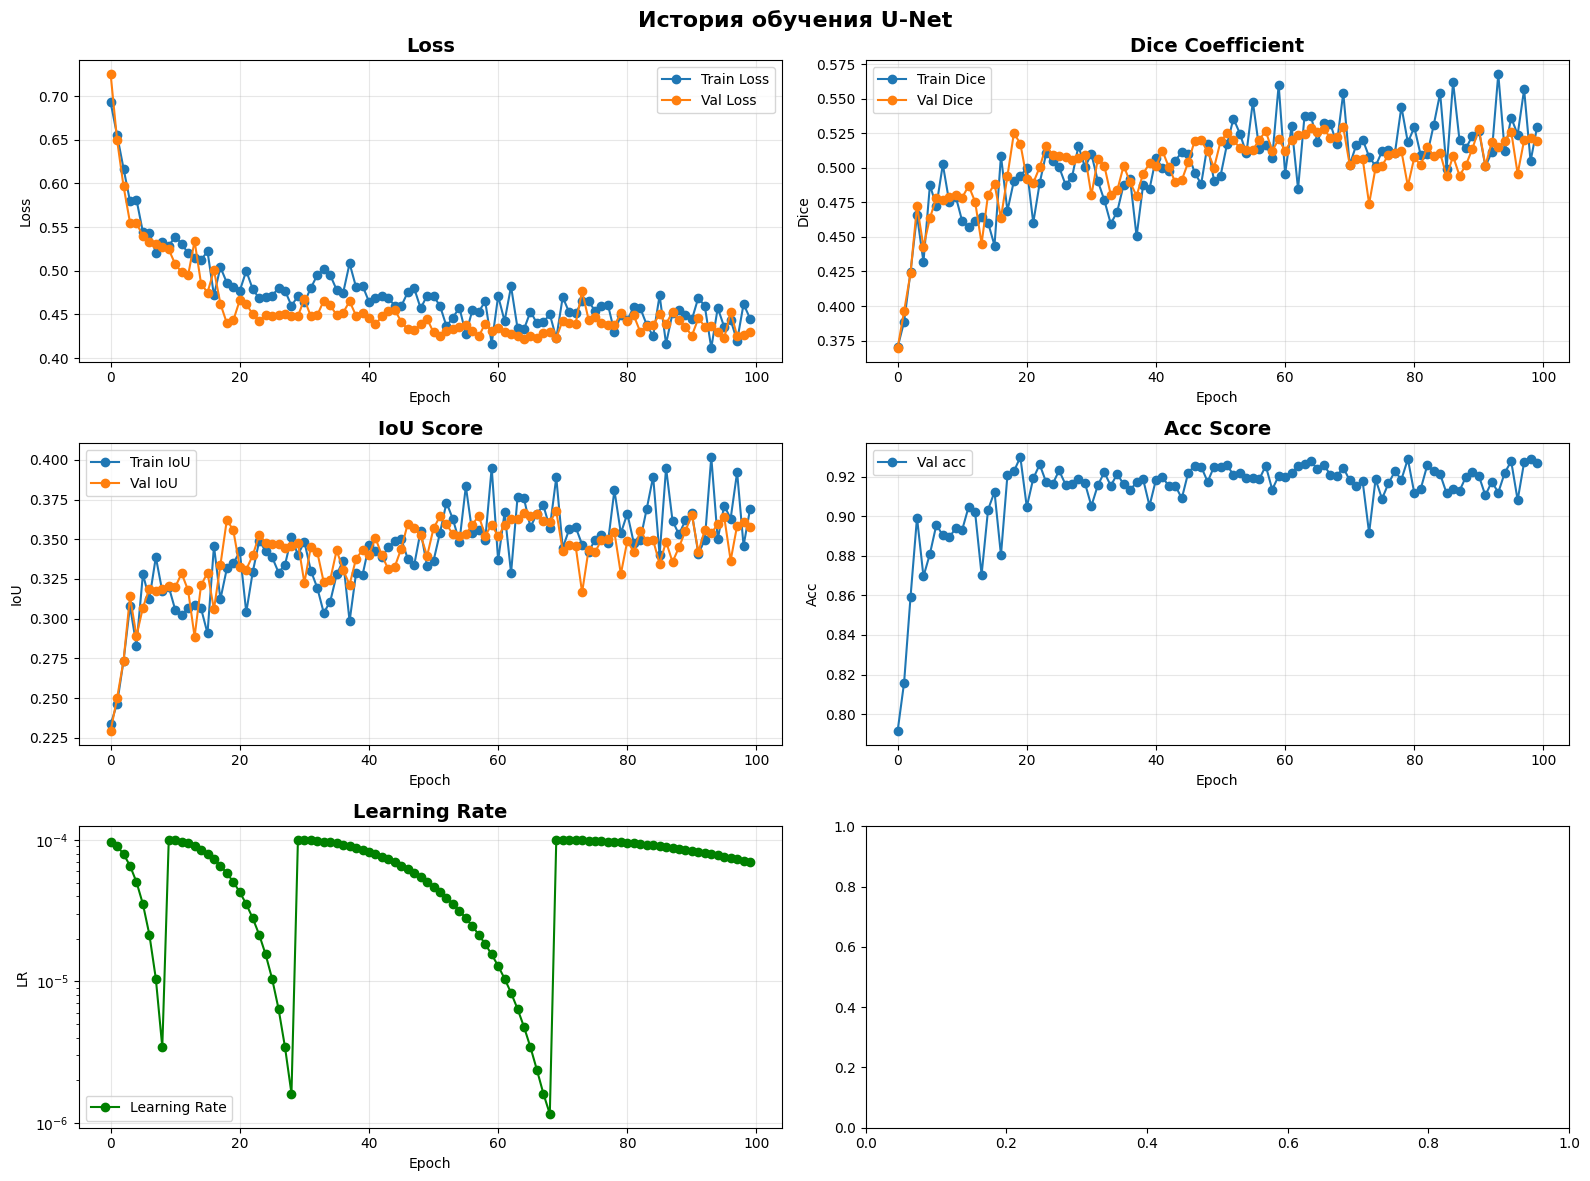

Train Loss: 0.4453
Val Loss: 0.4299
Train Dice: 0.5293
Val Dice: 0.5197
Train IoU: 0.3689
Val IoU: 0.3577
Val Accuracy: 0.9269


In [43]:
plot_training_history(my_history_freeze_part)

Эпоха: 70
Val Dice: 0.5293
Val IoU: 0.3676
Val Accuracy: 0.9245


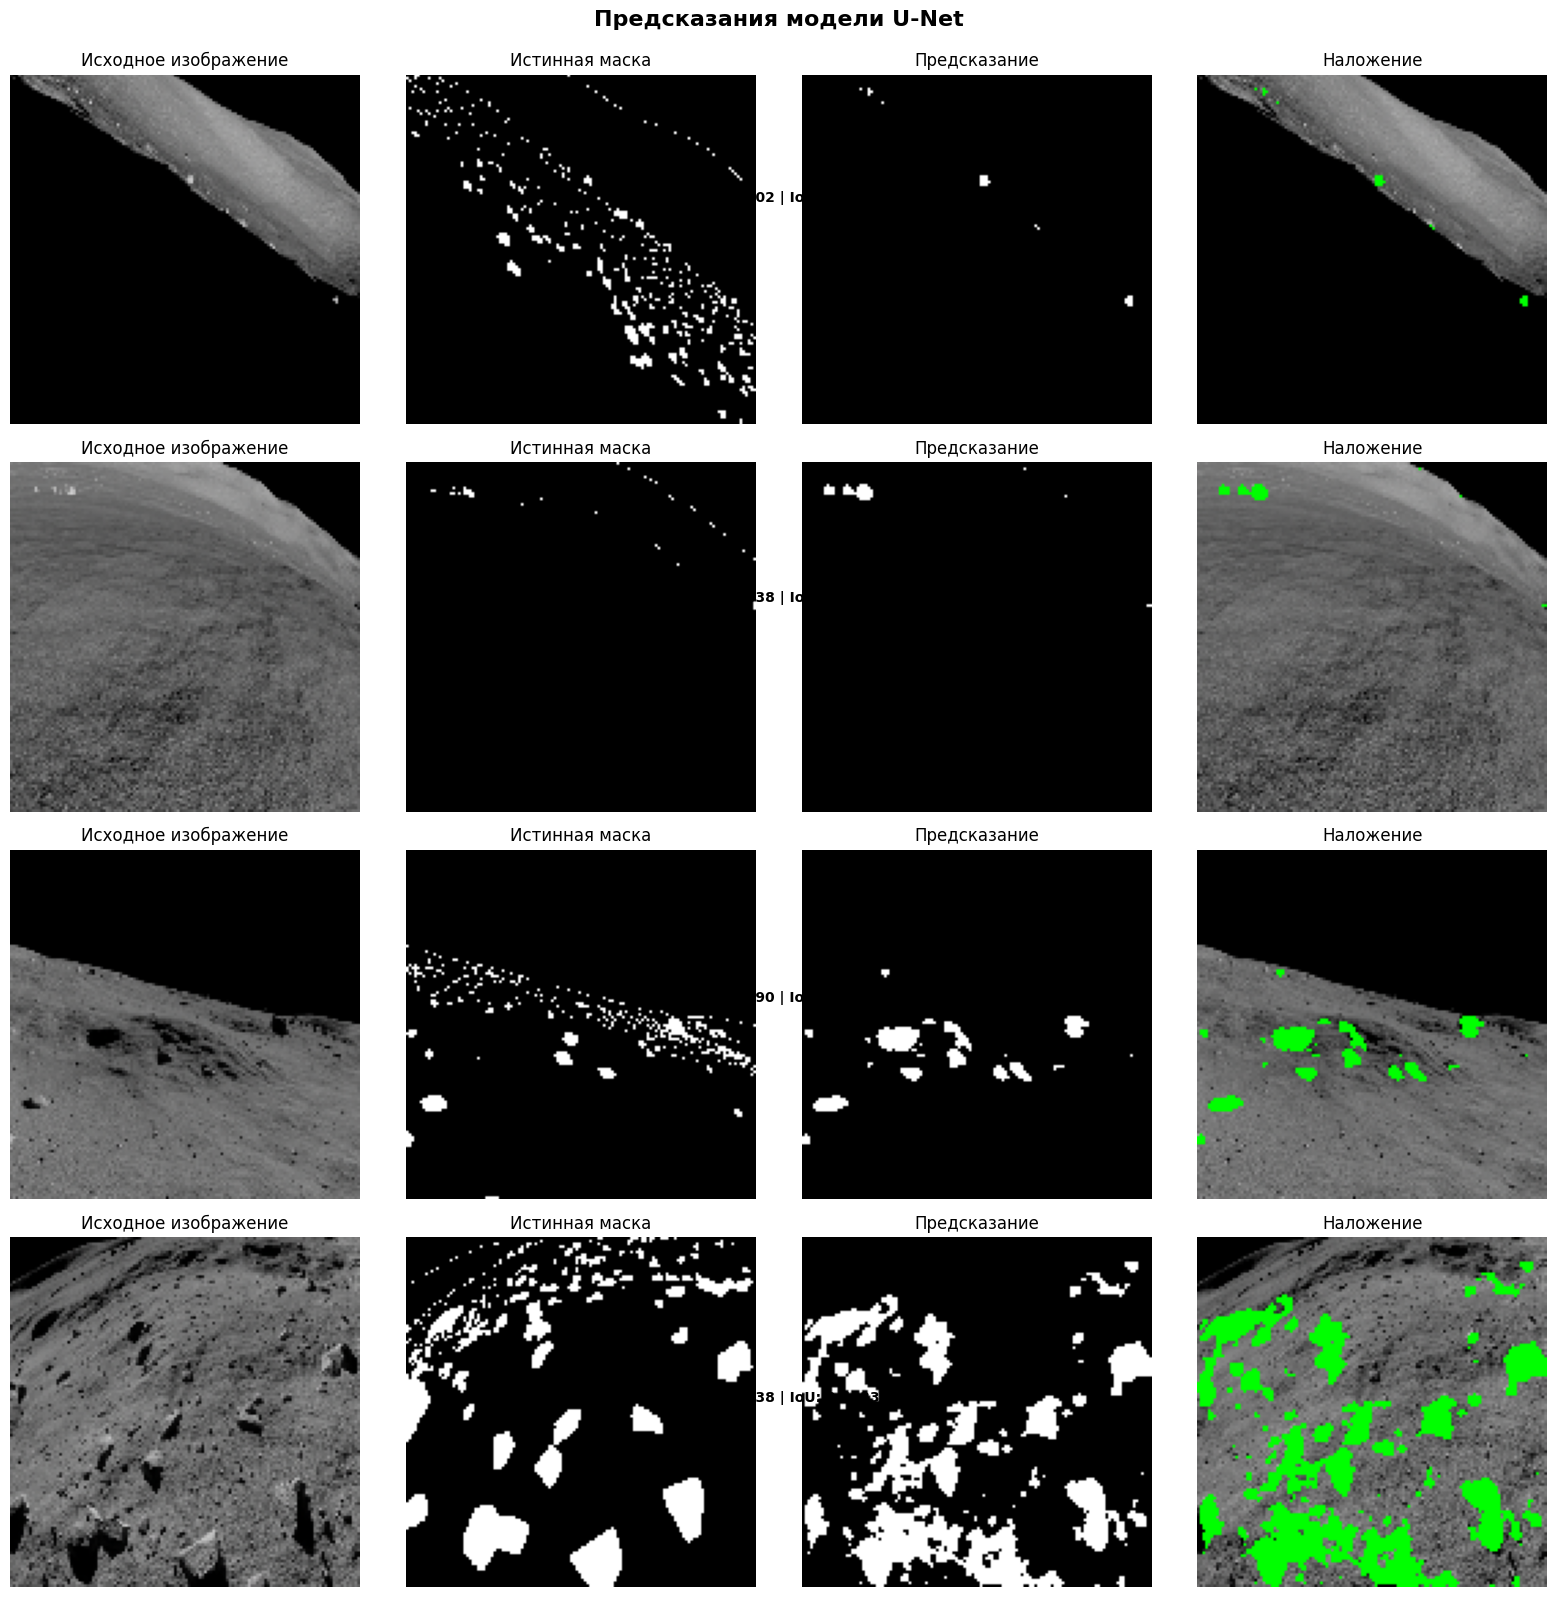

In [44]:
best_model = MyNNUNetFreeze(out_channels=1, freeze_all=False)

checkpoint_unet_freeze_part = torch.load(SAVE_PATH_FREEZE_PART, map_location=device)
best_model.load_state_dict(checkpoint_unet_freeze_part['model_state_dict'])
best_model = best_model.to(device)

print(f"Эпоха: {checkpoint_unet_freeze_part['epoch'] + 1}")
print(f"Val Dice: {checkpoint_unet_freeze_part['val_dice']:.4f}")
print(f"Val IoU: {checkpoint_unet_freeze_part['val_iou']:.4f}")
print(f"Val Accuracy: {checkpoint_unet_freeze_part['val_acc']:.4f}")

visualize_predictions(best_model, val_loader, device, num_samples=4)

## Сравнение

In [45]:

results = [
    {"Модель": "Base UNet", "Acc": checkpoint_unet['val_acc'], "Dice": checkpoint_unet['val_dice'], "IoU": checkpoint_unet['val_iou'], "Скорость сходимости": checkpoint_unet['epoch'] + 1},
    {"Модель": "3.1-A(энкодер заморожен)", "Acc": checkpoint_unet_freeze['val_acc'], "Dice": checkpoint_unet_freeze['val_dice'], "IoU": checkpoint_unet_freeze['val_iou'], "Скорость сходимости": checkpoint_unet_freeze['epoch'] + 1},
    {"Модель": "3.1-B(энкодер заморожен частично)", "Acc": checkpoint_unet_freeze_part['val_acc'], "Dice": checkpoint_unet_freeze_part['val_dice'], "IoU": checkpoint_unet_freeze_part['val_iou'], "Скорость сходимости": checkpoint_unet_freeze_part['epoch'] + 1},
]

df = pd.DataFrame(results)
print(df.to_markdown(index=False))

| Модель                            |      Acc |     Dice |      IoU |   Скорость сходимости |
|:----------------------------------|---------:|---------:|---------:|----------------------:|
| Base UNet                         | 0.919171 | 0.539324 | 0.375242 |                    97 |
| 3.1-A(энкодер заморожен)          | 0.92319  | 0.529155 | 0.365717 |                    95 |
| 3.1-B(энкодер заморожен частично) | 0.924521 | 0.529317 | 0.367585 |                    70 |


Базовая UNet оказалась лучший по метриками Dice и IoU. По точности лучше всего справилась модель 3.1-B. Но метрика Dice и IoU лучше отражает качество сегментации, поэтому среди данных архитектур лучшая Base UNet.